# Predicting the Next Year's Energy Demand in Great Britain using XGBoost

## Contents

1. [Importing Libraries & Packages](#1.-Importing-Libraries-&-Packages)  
2. [Pulling the Data](#2.-Pulling-the-Data)  
3. [Examining & Preparing the Data](#3.-Examining-&-Preparing-the-Data) 
4. [Feature Engineering](#4.-Feature-Engineering)
5. [Training the Model](#5.-Training-the-Model)
6. [Evaluating the Model](#6.-Evaluating-the-Model)
7. [Predicting Future Energy Use](#7.-Predicting-Future-Energy-Use)

## 1. Importing Libraries & Packages

Standard step for importing the required libraries and packages. Also setting colour pallette defaults used throughout project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb 
import os
import requests
import re
import shutil
import glob
import holidays
import optuna
import json

from statsmodels.graphics.tsaplots import plot_acf
from datetime import date, timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

[Back to Contents](#Contents)

## 2. Pulling the Data

The first proper step in our project is to use the NESO API to pull Britain's historical energy demand data. This comes in the form of yearly files that are occasionally changed retrospectively (almost always formatting changes to maintain consistency between years) and so each time we run this step (which definitely won't be every time we tinker with our model!), we will pull all of the yearly data files available.

Before examing our data more thoroughly, we then check that the correct number of years worth of data have been pulled from NESO by referencing the number of files available on their website for manual download (25), that our data is broadly complete by comparing the approximate number of rows we would expect to find with 48 entries a day (demand is recorded in half-hour time frames), and checking that the df has read in correctly with actual data available.

Here we see that at least some of our CSV files contain the relevant data (we aren't just loading in blank files!) and from reading the National Grid's [Demand Data Field Descriptions](https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fraw.githubusercontent.com%2Fmwinterdata%2FUKEnergyDemandXGBoost%2Frefs%2Fheads%2Fmain%2FDemandData%2520Field%2520Descriptions_1.doc&wdOrigin=BROWSELINK) we know that the 'ND' column is what we want to look at for the national energy demand of Great Britain. Also, from the [NESO FAQ](https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fraw.githubusercontent.com%2Fmwinterdata%2FUKEnergyDemandXGBoost%2Frefs%2Fheads%2Fmain%2Ffaq-neso.docx&wdOrigin=BROWSELINK), we know that this is measured in MW, and that it represents the average demand over half-hour period the 'SETTLEMENT_PERIOD' column (rather than say an instantaneous reading on exactly the half-hour). As 'SETTLEMENT_DATE' is fairly self explanatory (although also clarified in the above docs), we can now know that where the 'SETTLEMENT_DATE' is '2001-01-01', the 'SETTLEMENT_PERIOD' is '1', and the 'ND' is '38631', the average energy demand in Great Britain between 00:00am and 00:30am on the January 1st 2001 was 38,631MW. 


In [3]:
# 2.0. Delete folder if it already exists to avoid duplication as when pulling the data we will pull all of the files
#      to ensure that any historical data/formatting changes are accounted for
save_dir = "neso_energy_demand_data"
if os.path.exists(save_dir):
    print(f"Removing existing directory: {save_dir}")
    shutil.rmtree(save_dir)

# 2.1. Re-create the folder
os.makedirs(save_dir, exist_ok=True)

# 2.2. Query NESO API for data package info
api_url = "https://api.neso.energy/api/3/action/datapackage_show?id=historic-demand-data"
response = requests.get(api_url)

if response.status_code != 200:
    raise Exception(f"Failed to retrieve metadata from API: {response.status_code}")

data = response.json()

# 2.3. Extract URLs of CSV files
resources = data.get("result", {}).get("resources", [])
csv_resources = {
    res["name"]: res["path"]
    for res in resources
    if res.get("path", "").endswith(".csv")
}

# 2.4. Download each year's CSV file
for name, url in csv_resources.items():
    # Normalize filename
    filename = re.sub(r"[^\w\d_]+", "_", name.lower()) + ".csv"
    save_path = os.path.join(save_dir, filename)

    print(f"Downloading {filename} from {url}...")
    try:
        file_response = requests.get(url)
        file_response.raise_for_status()
        with open(save_path, "wb") as f:
            f.write(file_response.content)
    except Exception as e:
        print(f"Failed to download {name}: {e}")

print(f"\n Download complete. Files saved to '{save_dir}'")

Removing existing directory: neso_energy_demand_data

 Download complete. Files saved to 'neso_energy_demand_data'


In [4]:
# Path to directory containing CSVs
folder_path = 'neso_energy_demand_data'

# Get a list of all CSV file paths in the directory
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Read and concatenate all CSVs into one DataFrame
df_list = [pd.read_csv(file).assign(source=os.path.basename(file)) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Sense checking no. files & rows

today = date.today() 
day_of_year = today.timetuple().tm_yday
approx_rows_expected = int(48 * 365.25 * 24) + int(48 * day_of_year) # no. half hour periods in a day x avg. days in a year x no. years of data 
print(f"Loaded {len(csv_files)} CSV files.")
print(f"Rows in combined CSV file: {len(df):,}")
print(f"Approximate number of rows expected : {approx_rows_expected:,}")

Loaded 25 CSV files.
Rows in combined CSV file: 430,606
Approximate number of rows expected : 431,616


In [5]:
df.head()

SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND  TSD  ENGLAND_WALES_DEMAND  \
0      2001-01-01                  1  38631  NaN                 34060   
1      2001-01-01                  2  39808  NaN                 35370   
2      2001-01-01                  3  40039  NaN                 35680   
3      2001-01-01                  4  39339  NaN                 35029   
4      2001-01-01                  5  38295  NaN                 34047   

   EMBEDDED_WIND_GENERATION  EMBEDDED_WIND_CAPACITY  \
0                       NaN                     NaN   
1                       NaN                     NaN   
2                       NaN                     NaN   
3                       NaN                     NaN   
4                       NaN                     NaN   

   EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  ...  \
0                        NaN                      NaN            0  ...   
1                        NaN                      NaN            0  ...   
2                        NaN                      NaN            0  ...   
3                        NaN                      NaN            0  ...   
4                        NaN                      NaN            0  ...   

   IFA2_FLOW  BRITNED_FLOW  MOYLE_FLOW  EAST_WEST_FLOW  NEMO_FLOW  NSL_FLOW  \
0        NaN           NaN         NaN             NaN        NaN       NaN   
1        NaN           NaN         NaN             NaN        NaN       NaN   
2        NaN           NaN         NaN             NaN        NaN       NaN   
3        NaN           NaN         NaN             NaN        NaN       NaN   
4        NaN           NaN         NaN             NaN        NaN       NaN   

   ELECLINK_FLOW  VIKING_FLOW  GREENLINK_FLOW                         source  
0            NaN          NaN             NaN  historic_demand_data_2001.csv  
1            NaN          NaN             NaN  historic_demand_data_2001.csv  
2            NaN          NaN             NaN  historic_demand_data_2001.csv  
3            NaN          NaN             NaN  historic_demand_data_2001.csv  
4            NaN          NaN             NaN  historic_demand_data_2001.csv  

[5 rows x 23 columns]

In [6]:
df.tail()

SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND      TSD  \
430601      2025-07-24                 44  26672  30659.0   
430602      2025-07-24                 45  25725  29797.0   
430603      2025-07-24                 46  24986  28894.0   
430604      2025-07-24                 47  23553  27601.0   
430605      2025-07-24                 48  22807  26684.0   

        ENGLAND_WALES_DEMAND  EMBEDDED_WIND_GENERATION  \
430601                 24445                     591.0   
430602                 23458                     560.0   
430603                 22818                     529.0   
430604                 21524                     505.0   
430605                 20812                     481.0   

        EMBEDDED_WIND_CAPACITY  EMBEDDED_SOLAR_GENERATION  \
430601                  6606.0                        0.0   
430602                  6606.0                        0.0   
430603                  6606.0                        0.0   
430604                  6606.0                        0.0   
430605                  6606.0                        0.0   

        EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  ...  IFA2_FLOW  BRITNED_FLOW  \
430601                  19451.0            0  ...      991.0        -941.0   
430602                  19451.0            0  ...      965.0        -882.0   
430603                  19451.0            0  ...      963.0        -877.0   
430604                  19451.0            0  ...      989.0       -1014.0   
430605                  19451.0            0  ...      991.0       -1020.0   

        MOYLE_FLOW  EAST_WEST_FLOW  NEMO_FLOW  NSL_FLOW  ELECLINK_FLOW  \
430601      -451.0          -526.0     -334.0    1395.0          995.0   
430602      -451.0          -437.0     -361.0    1395.0          965.0   
430603      -451.0          -352.0     -364.0    1395.0          963.0   
430604      -387.0          -248.0     -412.0    1395.0          994.0   
430605      -246.0           -96.0     -415.0    1395.0          996.0   

        VIKING_FLOW  GREENLINK_FLOW                         source  
430601       -766.0          -468.0  historic_demand_data_2025.csv  
430602       -945.0          -494.0  historic_demand_data_2025.csv  
430603       -963.0          -397.0  historic_demand_data_2025.csv  
430604      -1082.0          -401.0  historic_demand_data_2025.csv  
430605      -1088.0          -508.0  historic_demand_data_2025.csv  

[5 rows x 23 columns]

[Back to Contents](#Contents)

# 3. Examining & Preparing the Data

Now that we have pulled our data and checked it is passing top level sense checks in its raw form, we want to make it a bit more user friendly and then examine it in detail. The first thing to note (apart from all the columns we don't need!), is that as explained in the [NESO FAQ](https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fraw.githubusercontent.com%2Fmwinterdata%2FUKEnergyDemandXGBoost%2Frefs%2Fheads%2Fmain%2Ffaq-neso.docx&wdOrigin=BROWSELINK) referenced above, all of the 'SETTLEMENT_PERIOD' values represent a half hour segment in UK local time. As the clocks in the UK go forward an hour in March, and back an hour in October, we may run into some formatting issues. 

This would be a minor issue and could affect our model in any circumstance, but it is a particularly big problem as the data we have pulled from the [NESO website](https://www.neso.energy/data-portal/historic-demand-data?page=1) only has a 'SETTLEMENT_DATE' column, with no exact time value, but instead relies on the 'SETTLEMENT_PERIOD' column as a substitute for this. Therefore, if we simply converted the 'SETTLEMENT_PERIOD' into a time by multiplying it by 30 minutes, we would run into issues where the 'SETTLEMENT_PERIOD' is over 48 (49, 50) where the clocks go back in October, meaning that some of our times will be duplicated and we could not create a unique datetime index.

There are multiple solutions to this issue, each with their own pros and cons, but the one I have gone with is to convert the datetime to UTC meaning that in the summer months during Daylight Saving Time we will have a datetime that is an hour behind the local time in Great Britain. This gives us a unique datetime index value with no duplicates due to times going back, and no missing values due to times going forward. It also means that every half hour period is represented for every single year, which is important for creating lagging values later on when we are engineering features ([4](#4.-Feature-Engineering)). 

However, once examining the data more fully and considering more how energy demand varies with the hour of the day (being highest during office hours), it becomes obvious that just using UTC time and not considering the local time around which so much energy demand behaviour depends, means our model would be missing vital information. We should therefore also create a non-index time column 'SETTLEMENT_DATETIME_LOCAL' column and accompanying it a boolean flag for whether it is daylight saving time (where BST = 1, GMT = 0) so that when we are engineering time based features ([4](#4.-Feature-Engineering)) we can include both local and UTC times. This may even give us additional insights into whether social drivers like the work day, or geographic factors like the sun setting, have a greater impact on energy demand.

Also at this stage we examine our data more fully and get a strong feeling for the cyclical patterns of energy demand in Great Britain both across and within years. We can see a clear decrease in energy usage since around the mid naughties although this appears to have subsided in recent years which tracks with other zoomed out [sources](https://oeuk.org.uk/mind-the-gap-between-uk-energy-consumption-and-production-warns-oeuk/). Then within years themselves we see expected energy demand rises in colder months as heating is required in Great Britain, although this drops off towards the end of December and beginning of January presumably as many people are off of work/school which will dramatically reduce business energy demand. We can also see on a more granular level two daily peaks at the beginning and end of the work day, and general higher values during it. On a weekly scale we can also appear to see two lower days corresponding to weekends. Hopefully our model will be able to pick up all of these fluctuations moving forward!

Ordinarily, once we have examined and done basic essential data preparation, we would want to clean up our data for any extreme outliers, potential errors,  or missing values. The NESO data is so comprehensive though, and upon examination there are few if any outliers that do not track with a clear pattern of usage (with the particularly low trough in Spring/Summer 2020 due to COVID lockdowns being the only possible exception), that any attempt to clean the data is likely to be more hindrance than help. As such, this step has been skipped for this project and we can move on to [Feature Engineering](#4.-Feature-Engineering).

In [7]:
df_clocks_back = df.loc[df['SETTLEMENT_PERIOD'] > 48]

print(df_clocks_back[['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD']].head(10))

      SETTLEMENT_DATE  SETTLEMENT_PERIOD
14446      2001-10-28                 49
14447      2001-10-28                 50
31918      2002-10-27                 49
31919      2002-10-27                 50
49390      2003-10-26                 49
49391      2003-10-26                 50
67198      2004-10-31                 49
67199      2004-10-31                 50
84670      2005-10-30                 49
84671      2005-10-30                 50


In [8]:
def build_settlement_datetime(
    df,
    date_col='SETTLEMENT_DATE',
    period_col='SETTLEMENT_PERIOD',
    set_index=True,
    add_dst_columns=True
):
    out = df.copy()

    # Ensure date is date-only (no time component)
    out[date_col] = pd.to_datetime(out[date_col]).dt.normalize()

    # 46/48/50 periods per day
    periods_per_day = out.groupby(out[date_col])[period_col].transform('max')
    p = pd.to_numeric(out[period_col], errors='coerce').astype('Int64')

    # Base minutes from midnight
    base_min = (p - 1) * 30

    # Adjust for clock changes (GB electricity market convention)
    adj_min = np.where(
        (periods_per_day == 50) & (p >= 5), base_min - 60,      # fall-back: duplicate hour
        np.where((periods_per_day == 46) & (p >= 3), base_min + 60,  # spring-forward: missing hour
                 base_min)
    )

    # Build naive local wall-clock datetimes
    dt_local_naive = out[date_col] + pd.to_timedelta(adj_min, unit='m')

    # Localize to Europe/London (handle DST transitions robustly)
    dt_local = pd.DatetimeIndex(dt_local_naive).tz_localize(
        'Europe/London', ambiguous='infer', nonexistent='shift_forward'
    )

    # Keep local time as a column
    out['SETTLEMENT_DATETIME_LOCAL'] = dt_local

    # Also create UTC version for index
    dt_utc = dt_local.tz_convert('UTC')
    out['SETTLEMENT_DATETIME_UTC'] = dt_utc

    if add_dst_columns:
        # Abbreviation: 'GMT' (Greenwich Mean Time) or 'BST' (British Summer Time)
        tz_abbrev = pd.Index(dt_local).map(lambda ts: ts.tzname())
        out['TZ_ABBREV'] = tz_abbrev
        
        # Boolean flag for Daylight Saving Time (BST = 1, GMT = 0)
        is_dst = pd.Index(dt_local).map(lambda ts: ts.dst() is not None and ts.dst().total_seconds() != 0)
        out['IS_BST'] = is_dst.astype(int)

        # Numeric UTC offset in hours (0 for GMT, 1 for BST)
        utc_offset_hours = pd.Index(dt_local).map(lambda ts: ts.utcoffset().total_seconds() / 3600.0)
        out['UTC_OFFSET_HOURS'] = utc_offset_hours.astype(float)

    # Set UTC datetime as index
    if set_index:
        out = out.set_index('SETTLEMENT_DATETIME_UTC')

    return out

In [9]:
df = build_settlement_datetime(df, 'SETTLEMENT_DATE', 'SETTLEMENT_PERIOD')
df = df.sort_index()

# sense checks
print(df.index.dtype)          # should show datetime64[ns, UTC]
print(df.index.is_unique)      # should be True

datetime64[ns, UTC]
True


In [10]:
df_clocks_back_check = df.loc[(df.index > '2001-10-27 22:00') & (df.index < '2001-10-28 03:00')][['SETTLEMENT_DATETIME_LOCAL', 'SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ND']]

print(df_clocks_back_check)

                          SETTLEMENT_DATETIME_LOCAL SETTLEMENT_DATE  \
SETTLEMENT_DATETIME_UTC                                               
2001-10-27 22:30:00+00:00 2001-10-27 23:30:00+01:00      2001-10-27   
2001-10-27 23:00:00+00:00 2001-10-28 00:00:00+01:00      2001-10-28   
2001-10-27 23:30:00+00:00 2001-10-28 00:30:00+01:00      2001-10-28   
2001-10-28 00:00:00+00:00 2001-10-28 01:00:00+01:00      2001-10-28   
2001-10-28 00:30:00+00:00 2001-10-28 01:30:00+01:00      2001-10-28   
2001-10-28 01:00:00+00:00 2001-10-28 01:00:00+00:00      2001-10-28   
2001-10-28 01:30:00+00:00 2001-10-28 01:30:00+00:00      2001-10-28   
2001-10-28 02:00:00+00:00 2001-10-28 02:00:00+00:00      2001-10-28   
2001-10-28 02:30:00+00:00 2001-10-28 02:30:00+00:00      2001-10-28   

                           SETTLEMENT_PERIOD     ND  
SETTLEMENT_DATETIME_UTC                              
2001-10-27 22:30:00+00:00                 48  30189  
2001-10-27 23:00:00+00:00                  1  28656  
20

In [11]:
df_clocks_forward_check = df.loc[(df.index > '2001-03-24 22:00') & (df.index < '2001-03-25 03:00')][['SETTLEMENT_DATETIME_LOCAL', 'SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ND']]

print(df_clocks_forward_check)

                          SETTLEMENT_DATETIME_LOCAL SETTLEMENT_DATE  \
SETTLEMENT_DATETIME_UTC                                               
2001-03-24 22:30:00+00:00 2001-03-24 22:30:00+00:00      2001-03-24   
2001-03-24 23:00:00+00:00 2001-03-24 23:00:00+00:00      2001-03-24   
2001-03-24 23:30:00+00:00 2001-03-24 23:30:00+00:00      2001-03-24   
2001-03-25 00:00:00+00:00 2001-03-25 00:00:00+00:00      2001-03-25   
2001-03-25 00:30:00+00:00 2001-03-25 00:30:00+00:00      2001-03-25   
2001-03-25 01:00:00+00:00 2001-03-25 02:00:00+01:00      2001-03-25   
2001-03-25 01:30:00+00:00 2001-03-25 02:30:00+01:00      2001-03-25   
2001-03-25 02:00:00+00:00 2001-03-25 03:00:00+01:00      2001-03-25   
2001-03-25 02:30:00+00:00 2001-03-25 03:30:00+01:00      2001-03-25   

                           SETTLEMENT_PERIOD     ND  
SETTLEMENT_DATETIME_UTC                              
2001-03-24 22:30:00+00:00                 46  37023  
2001-03-24 23:00:00+00:00                 47  35645  
20

In [12]:
df_issue_highlighting = df.loc[(df.index > '2001-07-25 21:00') & (df.index < '2001-07-26 02:00')][['SETTLEMENT_DATETIME_LOCAL','SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ND']]

print(df_issue_highlighting)

                          SETTLEMENT_DATETIME_LOCAL SETTLEMENT_DATE  \
SETTLEMENT_DATETIME_UTC                                               
2001-07-25 21:30:00+00:00 2001-07-25 22:30:00+01:00      2001-07-25   
2001-07-25 22:00:00+00:00 2001-07-25 23:00:00+01:00      2001-07-25   
2001-07-25 22:30:00+00:00 2001-07-25 23:30:00+01:00      2001-07-25   
2001-07-25 23:00:00+00:00 2001-07-26 00:00:00+01:00      2001-07-26   
2001-07-25 23:30:00+00:00 2001-07-26 00:30:00+01:00      2001-07-26   
2001-07-26 00:00:00+00:00 2001-07-26 01:00:00+01:00      2001-07-26   
2001-07-26 00:30:00+00:00 2001-07-26 01:30:00+01:00      2001-07-26   
2001-07-26 01:00:00+00:00 2001-07-26 02:00:00+01:00      2001-07-26   
2001-07-26 01:30:00+00:00 2001-07-26 02:30:00+01:00      2001-07-26   

                           SETTLEMENT_PERIOD     ND  
SETTLEMENT_DATETIME_UTC                              
2001-07-25 21:30:00+00:00                 46  33736  
2001-07-25 22:00:00+00:00                 47  31398  
20

In [13]:
df.head()

SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND  TSD  \
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00      2001-01-01                  1  38631  NaN   
2001-01-01 00:30:00+00:00      2001-01-01                  2  39808  NaN   
2001-01-01 01:00:00+00:00      2001-01-01                  3  40039  NaN   
2001-01-01 01:30:00+00:00      2001-01-01                  4  39339  NaN   
2001-01-01 02:00:00+00:00      2001-01-01                  5  38295  NaN   

                           ENGLAND_WALES_DEMAND  EMBEDDED_WIND_GENERATION  \
SETTLEMENT_DATETIME_UTC                                                     
2001-01-01 00:00:00+00:00                 34060                       NaN   
2001-01-01 00:30:00+00:00                 35370                       NaN   
2001-01-01 01:00:00+00:00                 35680                       NaN   
2001-01-01 01:30:00+00:00                 35029                       NaN   
2001-01-01 02:00:00+00:00                 34047                       NaN   

                           EMBEDDED_WIND_CAPACITY  EMBEDDED_SOLAR_GENERATION  \
SETTLEMENT_DATETIME_UTC                                                        
2001-01-01 00:00:00+00:00                     NaN                        NaN   
2001-01-01 00:30:00+00:00                     NaN                        NaN   
2001-01-01 01:00:00+00:00                     NaN                        NaN   
2001-01-01 01:30:00+00:00                     NaN                        NaN   
2001-01-01 02:00:00+00:00                     NaN                        NaN   

                           EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  ...  \
SETTLEMENT_DATETIME_UTC                                          ...   
2001-01-01 00:00:00+00:00                      NaN            0  ...   
2001-01-01 00:30:00+00:00                      NaN            0  ...   
2001-01-01 01:00:00+00:00                      NaN            0  ...   
2001-01-01 01:30:00+00:00                      NaN            0  ...   
2001-01-01 02:00:00+00:00                      NaN            0  ...   

                           NEMO_FLOW  NSL_FLOW  ELECLINK_FLOW  VIKING_FLOW  \
SETTLEMENT_DATETIME_UTC                                                      
2001-01-01 00:00:00+00:00        NaN       NaN            NaN          NaN   
2001-01-01 00:30:00+00:00        NaN       NaN            NaN          NaN   
2001-01-01 01:00:00+00:00        NaN       NaN            NaN          NaN   
2001-01-01 01:30:00+00:00        NaN       NaN            NaN          NaN   
2001-01-01 02:00:00+00:00        NaN       NaN            NaN          NaN   

                           GREENLINK_FLOW                         source  \
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00             NaN  historic_demand_data_2001.csv   
2001-01-01 00:30:00+00:00             NaN  historic_demand_data_2001.csv   
2001-01-01 01:00:00+00:00             NaN  historic_demand_data_2001.csv   
2001-01-01 01:30:00+00:00             NaN  historic_demand_data_2001.csv   
2001-01-01 02:00:00+00:00             NaN  historic_demand_data_2001.csv   

                           SETTLEMENT_DATETIME_LOCAL  TZ_ABBREV  IS_BST  \
SETTLEMENT_DATETIME_UTC                                                   
2001-01-01 00:00:00+00:00  2001-01-01 00:00:00+00:00        GMT       0   
2001-01-01 00:30:00+00:00  2001-01-01 00:30:00+00:00        GMT       0   
2001-01-01 01:00:00+00:00  2001-01-01 01:00:00+00:00        GMT       0   
2001-01-01 01:30:00+00:00  2001-01-01 01:30:00+00:00        GMT       0   
2001-01-01 02:00:00+00:00  2001-01-01 02:00:00+00:00        GMT       0   

                           UTC_OFFSET_HOURS  
SETTLEMENT_DATETIME_UTC                      
2001-01-01 00:00:00+00:00               0.0  
2001-01-01 00:30:00+00:00               0.0  
2001-01-01 01:00:00+00:00               0.0  
2001-01-01 01:30:00+00:00               0.0  
2001-

In [14]:
df = df[['ND', 'SETTLEMENT_DATETIME_LOCAL', 'IS_BST']]

In [15]:
df.head()

ND SETTLEMENT_DATETIME_LOCAL  IS_BST
SETTLEMENT_DATETIME_UTC                                           
2001-01-01 00:00:00+00:00  38631 2001-01-01 00:00:00+00:00       0
2001-01-01 00:30:00+00:00  39808 2001-01-01 00:30:00+00:00       0
2001-01-01 01:00:00+00:00  40039 2001-01-01 01:00:00+00:00       0
2001-01-01 01:30:00+00:00  39339 2001-01-01 01:30:00+00:00       0
2001-01-01 02:00:00+00:00  38295 2001-01-01 02:00:00+00:00       0

In [16]:
df.tail()

ND SETTLEMENT_DATETIME_LOCAL  IS_BST
SETTLEMENT_DATETIME_UTC                                           
2025-07-24 20:30:00+00:00  26672 2025-07-24 21:30:00+01:00       1
2025-07-24 21:00:00+00:00  25725 2025-07-24 22:00:00+01:00       1
2025-07-24 21:30:00+00:00  24986 2025-07-24 22:30:00+01:00       1
2025-07-24 22:00:00+00:00  23553 2025-07-24 23:00:00+01:00       1
2025-07-24 22:30:00+00:00  22807 2025-07-24 23:30:00+01:00       1

In [17]:
df['ND'].isnull().any()

False

In [18]:
# Boolean mask of which index entries are duplicates
mask = df.index.duplicated(keep=False)

# Show only the duplicate rows
duplicates = df[mask]

# See just the duplicate index values (unique)
duplicate_times = df.index[df.index.duplicated()].unique()

print("Duplicate timestamps found:", len(duplicate_times))
print(duplicate_times)

Duplicate timestamps found: 0
DatetimeIndex([], dtype='datetime64[ns, UTC]', name='SETTLEMENT_DATETIME_UTC', freq=None)


<Axes: title={'center': 'Great Britain National Demand in MW'}, xlabel='Date', ylabel='MW'>

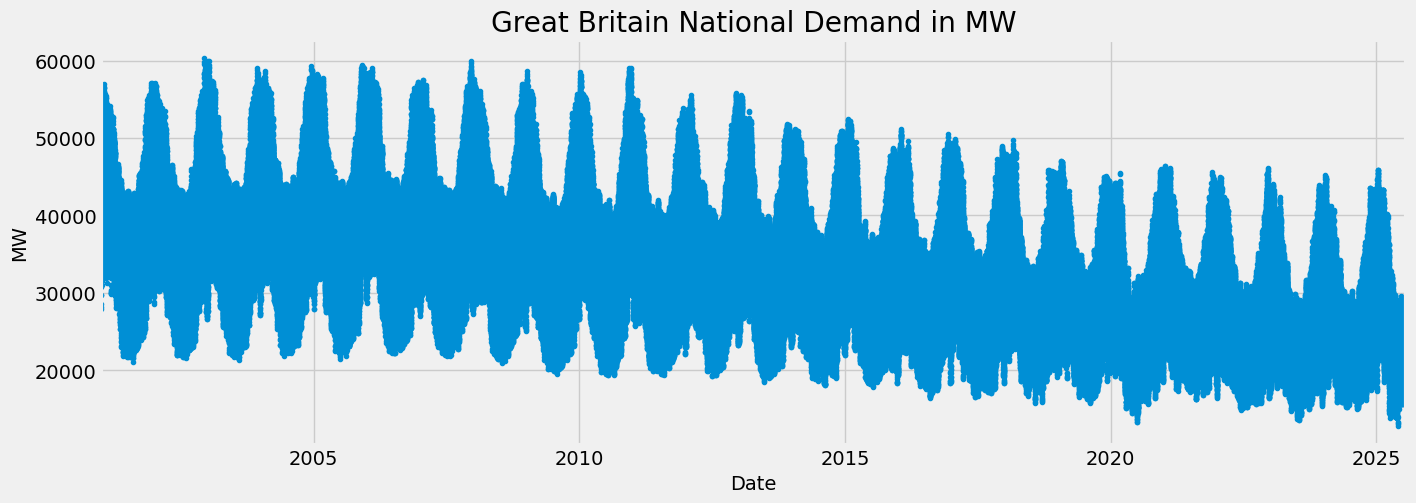

In [19]:
df['ND'].plot(style='.', 
        figsize=(15, 5), 
        color = color_pal[0], 
        title = 'Great Britain National Demand in MW', 
        xlabel = 'Date',
        ylabel = 'MW'
       )

Text(0, 0.5, 'Frequency')

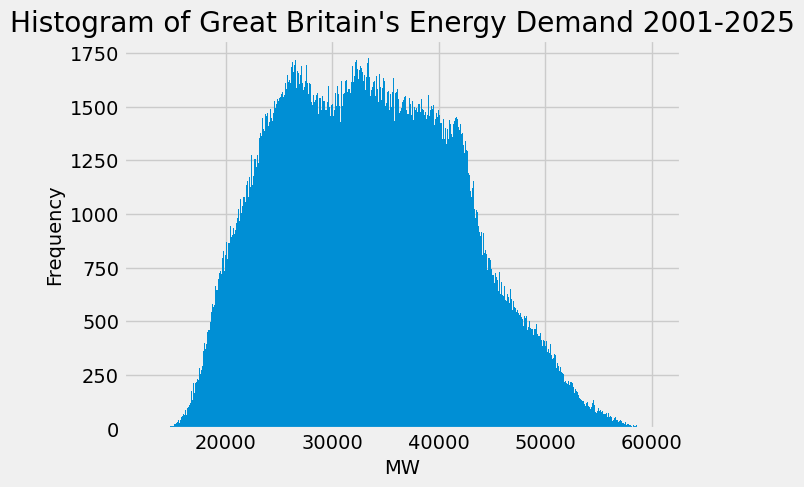

In [20]:
df['ND'].plot(kind='hist', bins=500, title="Histogram of Great Britain's Energy Demand 2001-2025")
plt.xlabel('MW')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

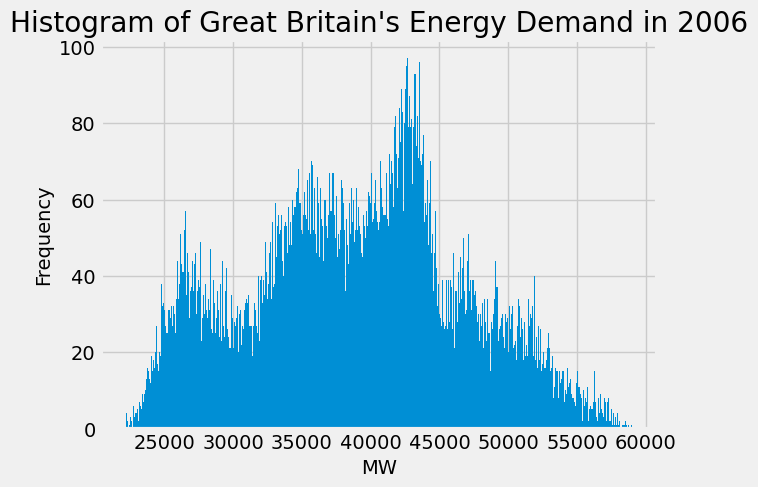

In [21]:
df.loc['2006', 'ND'].plot(kind='hist', bins=500, title="Histogram of Great Britain's Energy Demand in 2006")
plt.xlabel('MW')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

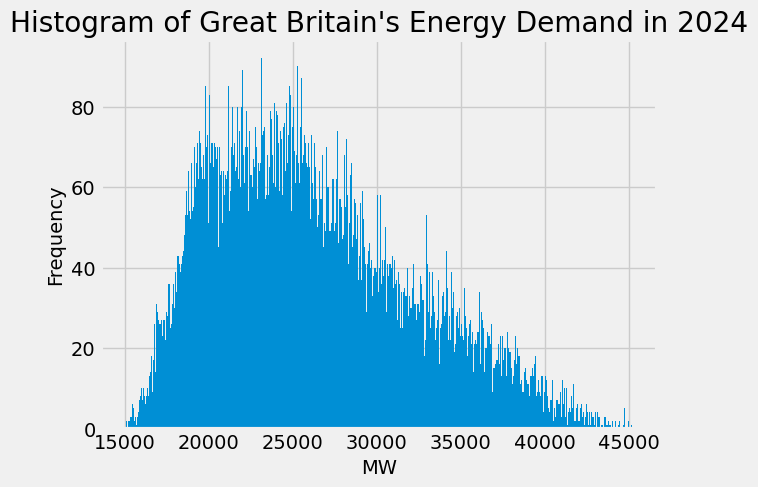

In [22]:
df.loc['2024', 'ND'].plot(kind='hist', bins=500, title="Histogram of Great Britain's Energy Demand in 2024")
plt.xlabel('MW')
plt.ylabel('Frequency')

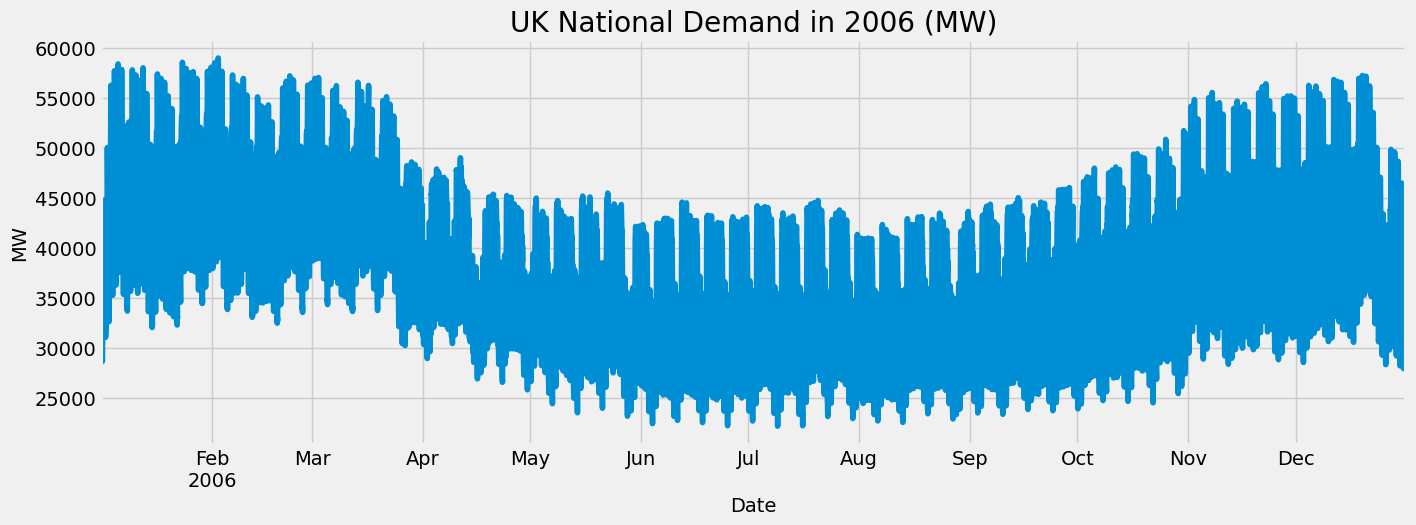

In [23]:
df.loc[(df.index > '2006-01-01') & (df.index < '2007-01-01')]['ND'] \
    .plot(figsize=(15, 5), title='UK National Demand in 2006 (MW)', xlabel = 'Date', ylabel = 'MW')
plt.show()

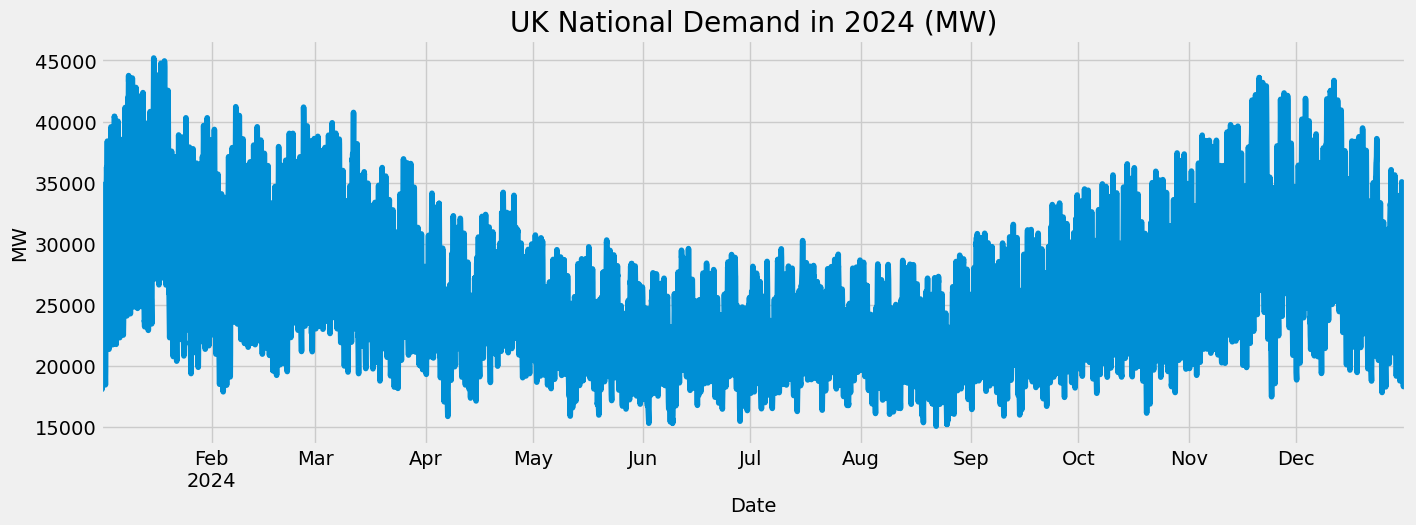

In [24]:
df.loc[(df.index > '2024-01-01') & (df.index < '2025-01-01')]['ND'] \
    .plot(figsize=(15, 5), title='UK National Demand in 2024 (MW)', xlabel = 'Date', ylabel = 'MW')
plt.show()

<Axes: title={'center': 'Example Week of Energy Demand'}, xlabel='Date', ylabel='MW'>

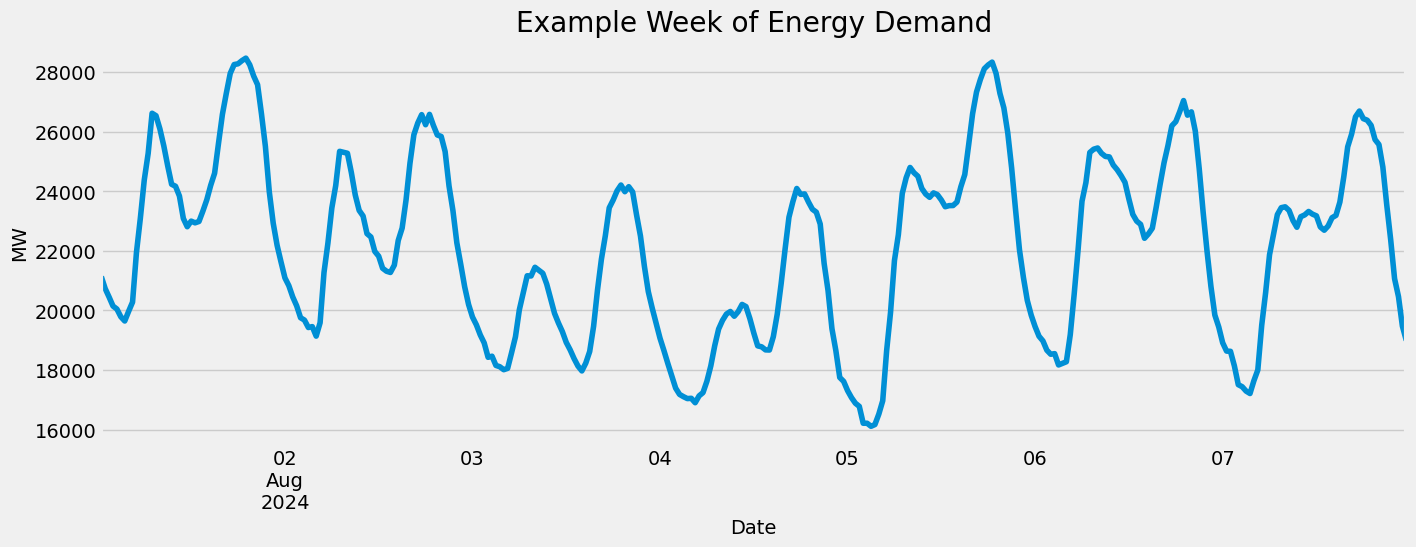

In [25]:
df.loc[(df.index > '2024-08-01') & (df.index < '2024-08-08')]['ND'].plot(figsize=(15, 5), 
                                                                         title='Example Week of Energy Demand',
                                                                         xlabel = 'Date',
                                                                         ylabel = 'MW'
                                                                        )

<Axes: title={'center': 'Example Day of Energy Demand'}, xlabel='Time', ylabel='MW'>

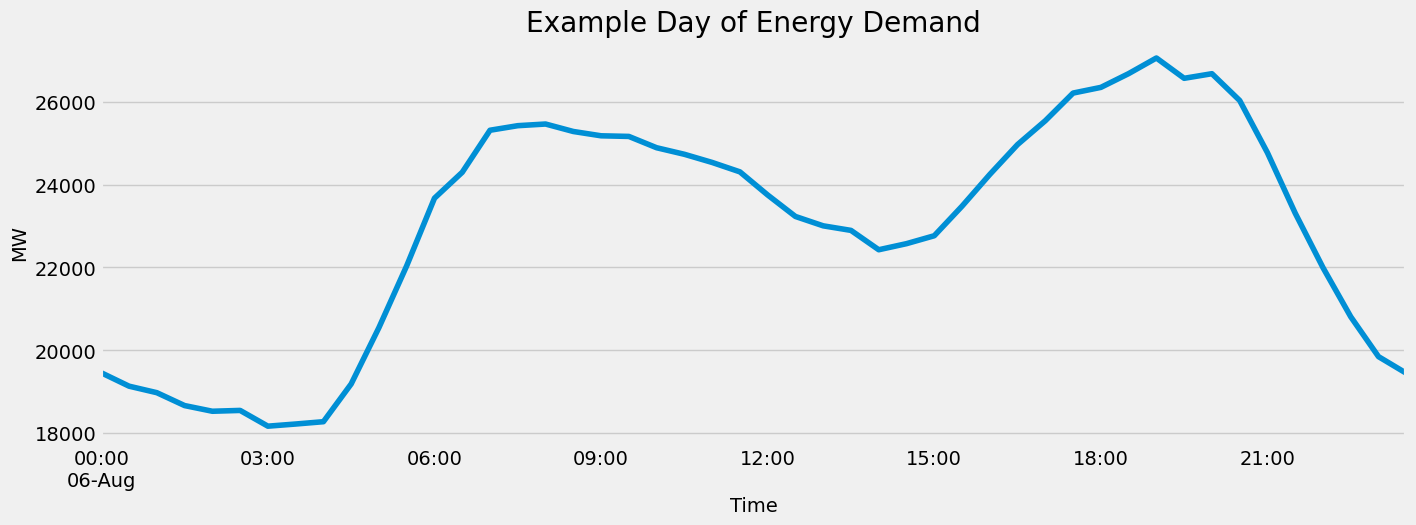

In [26]:
df.loc[(df.index >= '2024-08-06') & (df.index < '2024-08-07')]['ND'].plot(figsize=(15, 5), 
                                                                         title='Example Day of Energy Demand',
                                                                         xlabel = 'Time',
                                                                         ylabel = 'MW'
                                                                        )

<Axes: title={'center': 'Potential Top End Outliers'}, xlabel='Date', ylabel='MW'>

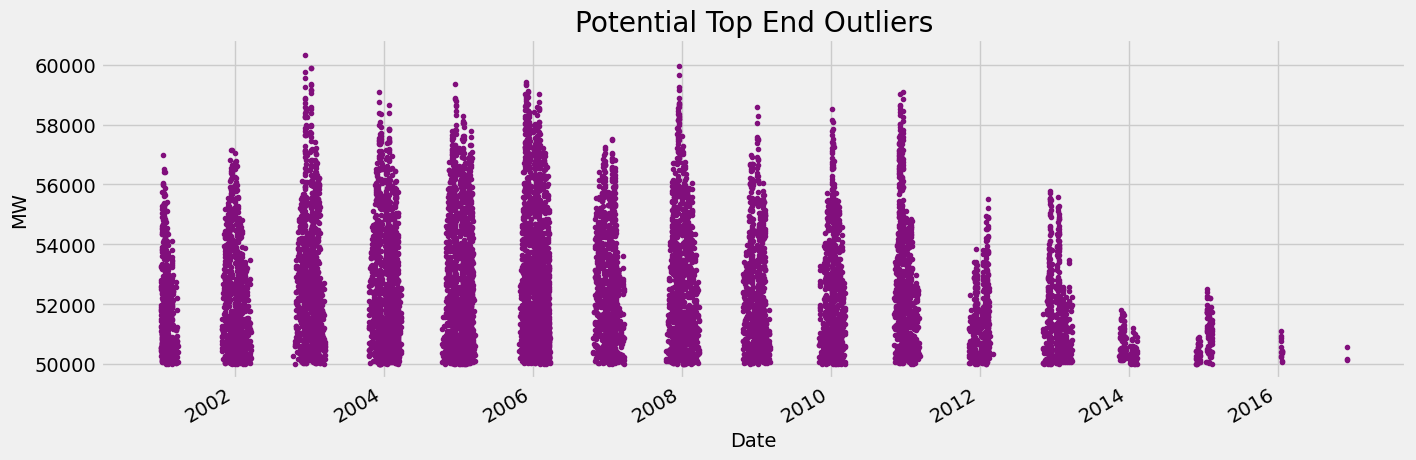

In [27]:
df.query('ND > 50000')['ND'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Potential Top End Outliers',
          xlabel = 'Date', 
          ylabel = 'MW'
         )

<Axes: title={'center': 'Potential Bottom End Outliers'}, xlabel='Date', ylabel='MW'>

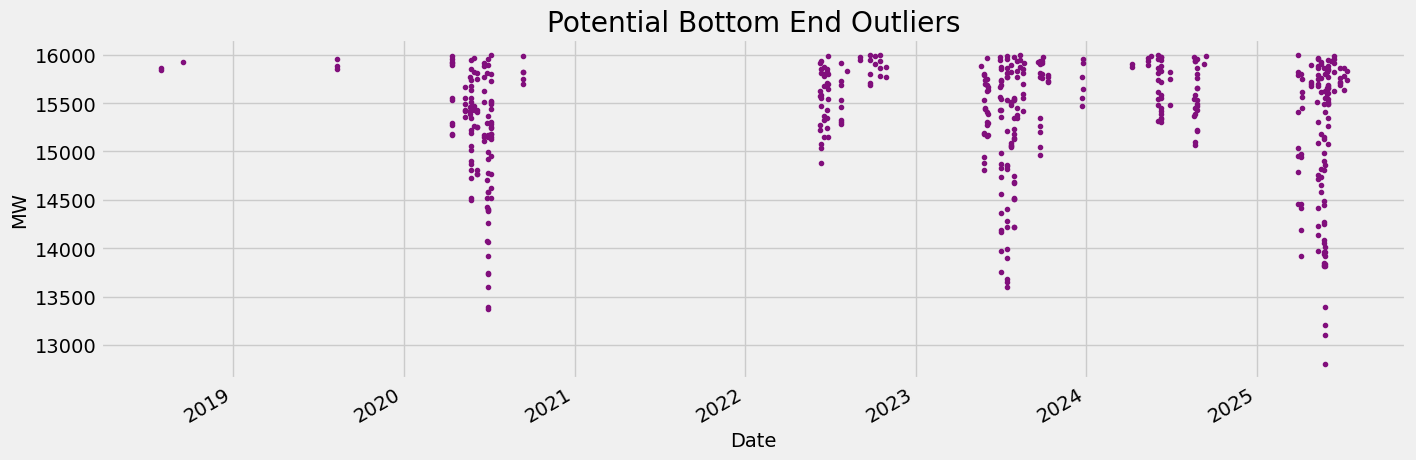

In [28]:
df.query('ND < 16000')['ND'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Potential Bottom End Outliers',
          xlabel = 'Date', 
          ylabel = 'MW'
         )

Although we do have some exceptionally low points of energy demand such as in 2025 when it drops below 13,000MW once, and in 2003 when it creeps above 60,000MW once, these look like genuine data points following the trends of the times of year. As such, and also because of the reliability and frequently updated nature of the NESO data, although it is good to be aware of these points we will not take any action to remove them as outliers at this time.

[Back to Contents](#Contents)

# 4. Feature Engineering

As we can see and was discussed above ([3](#3.-Examining-&-Preparing-the-Data)), the energy demand for Britain follows clearly cyclical patterns at yearly (seasonal), weekly (workweek vs weekend), and daily (peaks in the morning and evening), and so we will need to generate a set of calendar features that can help our model capture these changes to predict future energy demand. These naturally include a lot of overlap, such as 'day_of_week'/'is_weekend' and 'month'/'quarter' but that is absolutely fine! 

Our XGBoost will cycle through hundreds of decision trees trialling using these different features and will just put less emphasis on those that are less important, which will often be the case with istances of overlap. Technically this overlap will make our model run slightly slower, and so if we were dealing with tens or hundreds of millions of data points, or dozens and dozens of features, it might be worth trying to eliminate this redundancy. We could do this by finding out which overlapping columns were most effective for predictions and removing the rest. For this project though, model runtime is not an issue and so we are absolutely fine with some redundancy and will just let our model pick the most important features.

We will also add cyclical encoding for both the 'UTC_settlement_period' and 'local_settlement_period' (both for reasons discussed above in [Examining & Preparing the Data](#3.-Examining-&-Preparing-the-Data)). All this means is that we are changing the settlement period (sp) to cos and sin values, so that instead of there being a big jump from 23:30 (settlement period 48) and 00:00 (settlement period 1) numbers wise, our model can see that they are in fact next to each other reflecting how they will likely behave energy demand wise. As before we are still going to leave our local time and UTC settlement periods in there, just also give our model these cyclical features to experiement with. It can work out which is the most important from there!

The last of the calendar features we add is a True/False 'is_holiday' flag that will alert our model if there is a public holiday on that date. These may well have similar energy demand patterns as weekends despite being weekdays (or something else entirely) and so it is good that our model can if needed separate out these days and potentially adjust its predictions accoringly.

Finally in this section, we will add lag features. Lag features will allow us to look back in time to an exact point relative to each datetime, and feed this into our model for it to factor into its predictions. We could make lag features for any length of time from one half an hour period all the way up to 20 years if we so chose all we are going is going back a consistent time period for each entry. These can be extremely effective as features in short term predictions. For example if we were predicting the next week's energy demand, the last week's would likely be highly relevant as it would often have similar behaviour patterns and perhaps most important similar weather and daylight hours. In this case we would want to add lags to show net demand at the same time the day before and the same time on the same day the week before.

As we are doing a long term energy prediction of a full year though, if we were to use such short term lags we would run an incredibly high risk of compounding our errors. If we put in daily and weekly lags for example for 364 days and for 51 weeks respectively we would be using our predicted data with zero validation to make further predictions with. In 6 months time the weather and energy demand would likely be completely different to what it was when our original lag was used but our model would still be carrying over some of its effect from the first prediction. Therefore, we shall stick to using lags showing the weather at the exact same time and day one or more years previously so that we will have zero chance of compounding our errors.

Similarly, creating window calculations such as 30 or 7 day running means or standard deviations is an excellent tool for short term predictions and would often be included in the feature generation steps for predictive modelling like this. Again though this would create the potential for increasingly large errors over time and so we shall not use window calculations for this project.

In [29]:
def create_calendar_features(df):
    
    # Creating time series features based on time series index
    df = df.copy()
    df['hour']        = df.index.hour
    df['minute']      = df.index.minute
    df['day_of_week']   = df.index.dayofweek           # Mon=0 ... Sun=6
    df['is_weekend']  = df['day_of_week'] >= 5
    df['quarter']     = df.index.quarter
    df['month']       = df.index.month
    df['year']        = df.index.year
    df['day_of_year']   = df.index.dayofyear
    df['day_of_month']  = df.index.day
    df['week_of_year']  = df.index.isocalendar().week.astype(int)
    df['UTC_settlement_period'] = (df['hour'] * 2 + (df['minute'] // 30)) + 1
    df['local_settlement_period'] = (df['hour'] * 2 + (df['minute'] // 30)) + 1 + (df['IS_BST'] * 2)
    df['UTC_time'] = df.index.strftime('%H:%M')
    
    # Cyclical encoding for UTC_settlement_period
    max_sp = df['UTC_settlement_period'].max()
    df['UTC_sp_sin'] = np.sin(2 * np.pi * df['UTC_settlement_period'] / max_sp)
    df['UTC_sp_cos'] = np.cos(2 * np.pi * df['UTC_settlement_period'] / max_sp)
    
    # Cyclical encoding for local_settlement_period
    max_sp = df['local_settlement_period'].max()
    df['local_sp_sin'] = np.sin(2 * np.pi * df['local_settlement_period'] / max_sp)
    df['local_sp_cos'] = np.cos(2 * np.pi * df['local_settlement_period'] / max_sp)

    # Holiday flag
    uk_holidays = holidays.UnitedKingdom()
    
    df['holiday_name'] = (
    df.index.tz_convert(None)
      .normalize()
      .map(lambda d: uk_holidays.get(d))
    )
    
    df['is_holiday'] = df['holiday_name'].notna()

    return df

In [30]:
df = create_calendar_features(df)

In [31]:
df.head()

ND SETTLEMENT_DATETIME_LOCAL  IS_BST  hour  \
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00  38631 2001-01-01 00:00:00+00:00       0     0   
2001-01-01 00:30:00+00:00  39808 2001-01-01 00:30:00+00:00       0     0   
2001-01-01 01:00:00+00:00  40039 2001-01-01 01:00:00+00:00       0     1   
2001-01-01 01:30:00+00:00  39339 2001-01-01 01:30:00+00:00       0     1   
2001-01-01 02:00:00+00:00  38295 2001-01-01 02:00:00+00:00       0     2   

                           minute  day_of_week  is_weekend  quarter  month  \
SETTLEMENT_DATETIME_UTC                                                      
2001-01-01 00:00:00+00:00       0            0       False        1      1   
2001-01-01 00:30:00+00:00      30            0       False        1      1   
2001-01-01 01:00:00+00:00       0            0       False        1      1   
2001-01-01 01:30:00+00:00      30            0       False        1      1   
2001-01-01 02:00:00+00:00       0            0       False        1      1   

                           year  ...  week_of_year  UTC_settlement_period  \
SETTLEMENT_DATETIME_UTC          ...                                        
2001-01-01 00:00:00+00:00  2001  ...             1                      1   
2001-01-01 00:30:00+00:00  2001  ...             1                      2   
2001-01-01 01:00:00+00:00  2001  ...             1                      3   
2001-01-01 01:30:00+00:00  2001  ...             1                      4   
2001-01-01 02:00:00+00:00  2001  ...             1                      5   

                           local_settlement_period  UTC_time  UTC_sp_sin  \
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00                        1     00:00    0.130526   
2001-01-01 00:30:00+00:00                        2     00:30    0.258819   
2001-01-01 01:00:00+00:00                        3     01:00    0.382683   
2001-01-01 01:30:00+00:00                        4     01:30    0.500000   
2001-01-01 02:00:00+00:00                        5     02:00    0.608761   

                          UTC_sp_cos  local_sp_sin  local_sp_cos  \
SETTLEMENT_DATETIME_UTC                                            
2001-01-01 00:00:00+00:00   0.991445      0.125333      0.992115   
2001-01-01 00:30:00+00:00   0.965926      0.248690      0.968583   
2001-01-01 01:00:00+00:00   0.923880      0.368125      0.929776   
2001-01-01 01:30:00+00:00   0.866025      0.481754      0.876307   
2001-01-01 02:00:00+00:00   0.793353      0.587785      0.809017   

                             holiday_name  is_holiday  
SETTLEMENT_DATETIME_UTC                                
2001-01-01 00:00:00+00:00  New Year's Day        True  
2001-01-01 00:30:00+00:00  New Year's Day        True  
2001-01-01 01:00:00+00:00  New Year's Day        True  
2001-01-01 01:30:00+00:00  New Year's Day        True  
2001-01-01 02:00:00+00:00  New Year's Day        True  

[5 rows x 22 columns]

In [32]:
def add_calendar_lags(df, target_col='ND', years=(1, 2, 3, 4, 5)):
    df = df.copy()
    s = df[target_col]

    for y in years:
        lag_idx = df.index - pd.DateOffset(years=y)
        df[f'{target_col}_exactly_{y}_years_ago'] = s.reindex(lag_idx).to_numpy()

    return df

In [33]:
df = add_calendar_lags(df, target_col='ND', years=(1,2,3,4,5))

In [34]:
df.head()

ND SETTLEMENT_DATETIME_LOCAL  IS_BST  hour  \
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00  38631 2001-01-01 00:00:00+00:00       0     0   
2001-01-01 00:30:00+00:00  39808 2001-01-01 00:30:00+00:00       0     0   
2001-01-01 01:00:00+00:00  40039 2001-01-01 01:00:00+00:00       0     1   
2001-01-01 01:30:00+00:00  39339 2001-01-01 01:30:00+00:00       0     1   
2001-01-01 02:00:00+00:00  38295 2001-01-01 02:00:00+00:00       0     2   

                           minute  day_of_week  is_weekend  quarter  month  \
SETTLEMENT_DATETIME_UTC                                                      
2001-01-01 00:00:00+00:00       0            0       False        1      1   
2001-01-01 00:30:00+00:00      30            0       False        1      1   
2001-01-01 01:00:00+00:00       0            0       False        1      1   
2001-01-01 01:30:00+00:00      30            0       False        1      1   
2001-01-01 02:00:00+00:00       0            0       False        1      1   

                           year  ...  UTC_sp_cos  local_sp_sin  local_sp_cos  \
SETTLEMENT_DATETIME_UTC          ...                                           
2001-01-01 00:00:00+00:00  2001  ...    0.991445      0.125333      0.992115   
2001-01-01 00:30:00+00:00  2001  ...    0.965926      0.248690      0.968583   
2001-01-01 01:00:00+00:00  2001  ...    0.923880      0.368125      0.929776   
2001-01-01 01:30:00+00:00  2001  ...    0.866025      0.481754      0.876307   
2001-01-01 02:00:00+00:00  2001  ...    0.793353      0.587785      0.809017   

                             holiday_name  is_holiday ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME_UTC                                                        
2001-01-01 00:00:00+00:00  New Year's Day        True                    NaN   
2001-01-01 00:30:00+00:00  New Year's Day        True                    NaN   
2001-01-01 01:00:00+00:00  New Year's Day        True                    NaN   
2001-01-01 01:30:00+00:00  New Year's Day        True                    NaN   
2001-01-01 02:00:00+00:00  New Year's Day        True                    NaN   

                           ND_exactly_2_years_ago  ND_exactly_3_years_ago  \
SETTLEMENT_DATETIME_UTC                                                     
2001-01-01 00:00:00+00:00                     NaN                     NaN   
2001-01-01 00:30:00+00:00                     NaN                     NaN   
2001-01-01 01:00:00+00:00                     NaN                     NaN   
2001-01-01 01:30:00+00:00                     NaN                     NaN   
2001-01-01 02:00:00+00:00                     NaN                     NaN   

                           ND_exactly_4_years_ago  ND_exactly_5_years_ago  
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00                     NaN                     NaN  
2001-01-01 00:30:00+00:00                     NaN                     NaN  
2001-01-01 01:00:00+00:00                     NaN                     NaN  
2001-01-01 01:30:00+00:00                     NaN                     NaN  
2001-01-01 02:00:00+00:00                     NaN                     NaN  

[5 rows x 27 columns]

In [35]:
df.tail()

ND SETTLEMENT_DATETIME_LOCAL  IS_BST  hour  \
SETTLEMENT_DATETIME_UTC                                                    
2025-07-24 20:30:00+00:00  26672 2025-07-24 21:30:00+01:00       1    20   
2025-07-24 21:00:00+00:00  25725 2025-07-24 22:00:00+01:00       1    21   
2025-07-24 21:30:00+00:00  24986 2025-07-24 22:30:00+01:00       1    21   
2025-07-24 22:00:00+00:00  23553 2025-07-24 23:00:00+01:00       1    22   
2025-07-24 22:30:00+00:00  22807 2025-07-24 23:30:00+01:00       1    22   

                           minute  day_of_week  is_weekend  quarter  month  \
SETTLEMENT_DATETIME_UTC                                                      
2025-07-24 20:30:00+00:00      30            3       False        3      7   
2025-07-24 21:00:00+00:00       0            3       False        3      7   
2025-07-24 21:30:00+00:00      30            3       False        3      7   
2025-07-24 22:00:00+00:00       0            3       False        3      7   
2025-07-24 22:30:00+00:00      30            3       False        3      7   

                           year  ...  UTC_sp_cos  local_sp_sin  local_sp_cos  \
SETTLEMENT_DATETIME_UTC          ...                                           
2025-07-24 20:30:00+00:00  2025  ...    0.707107     -0.684547      0.728969   
2025-07-24 21:00:00+00:00  2025  ...    0.793353     -0.587785      0.809017   
2025-07-24 21:30:00+00:00  2025  ...    0.866025     -0.481754      0.876307   
2025-07-24 22:00:00+00:00  2025  ...    0.923880     -0.368125      0.929776   
2025-07-24 22:30:00+00:00  2025  ...    0.965926     -0.248690      0.968583   

                           holiday_name  is_holiday ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME_UTC                                                      
2025-07-24 20:30:00+00:00          None       False                25505.0   
2025-07-24 21:00:00+00:00          None       False                24191.0   
2025-07-24 21:30:00+00:00          None       False                23189.0   
2025-07-24 22:00:00+00:00          None       False                22515.0   
2025-07-24 22:30:00+00:00          None       False                21066.0   

                           ND_exactly_2_years_ago  ND_exactly_3_years_ago  \
SETTLEMENT_DATETIME_UTC                                                     
2025-07-24 20:30:00+00:00                 25436.0                 23922.0   
2025-07-24 21:00:00+00:00                 24425.0                 23341.0   
2025-07-24 21:30:00+00:00                 23220.0                 22040.0   
2025-07-24 22:00:00+00:00                 21944.0                 20737.0   
2025-07-24 22:30:00+00:00                 20894.0                 19511.0   

                           ND_exactly_4_years_ago  ND_exactly_5_years_ago  
SETTLEMENT_DATETIME_UTC                                                    
2025-07-24 20:30:00+00:00                 25797.0                 25940.0  
2025-07-24 21:00:00+00:00                 25254.0                 25164.0  
2025-07-24 21:30:00+00:00                 24288.0                 23773.0  
2025-07-24 22:00:00+00:00                 23067.0                 22368.0  
2025-07-24 22:30:00+00:00                 22001.0                 21035.0  

[5 rows x 27 columns]

In [36]:
df.loc[(df.index > '2024-08-01') & (df.index < '2024-08-08')]

ND SETTLEMENT_DATETIME_LOCAL  IS_BST  hour  \
SETTLEMENT_DATETIME_UTC                                                    
2024-08-01 00:30:00+00:00  21139 2024-08-01 01:30:00+01:00       1     0   
2024-08-01 01:00:00+00:00  20735 2024-08-01 02:00:00+01:00       1     1   
2024-08-01 01:30:00+00:00  20450 2024-08-01 02:30:00+01:00       1     1   
2024-08-01 02:00:00+00:00  20148 2024-08-01 03:00:00+01:00       1     2   
2024-08-01 02:30:00+00:00  20048 2024-08-01 03:30:00+01:00       1     2   
...                          ...                       ...     ...   ...   
2024-08-07 21:30:00+00:00  22384 2024-08-07 22:30:00+01:00       1    21   
2024-08-07 22:00:00+00:00  21068 2024-08-07 23:00:00+01:00       1    22   
2024-08-07 22:30:00+00:00  20468 2024-08-07 23:30:00+01:00       1    22   
2024-08-07 23:00:00+00:00  19476 2024-08-08 00:00:00+01:00       1    23   
2024-08-07 23:30:00+00:00  18994 2024-08-08 00:30:00+01:00       1    23   

                           minute  day_of_week  is_weekend  quarter  month  \
SETTLEMENT_DATETIME_UTC                                                      
2024-08-01 00:30:00+00:00      30            3       False        3      8   
2024-08-01 01:00:00+00:00       0            3       False        3      8   
2024-08-01 01:30:00+00:00      30            3       False        3      8   
2024-08-01 02:00:00+00:00       0            3       False        3      8   
2024-08-01 02:30:00+00:00      30            3       False        3      8   
...                           ...          ...         ...      ...    ...   
2024-08-07 21:30:00+00:00      30            2       False        3      8   
2024-08-07 22:00:00+00:00       0            2       False        3      8   
2024-08-07 22:30:00+00:00      30            2       False        3      8   
2024-08-07 23:00:00+00:00       0            2       False        3      8   
2024-08-07 23:30:00+00:00      30            2       False        3      8   

                           year  ...  UTC_sp_cos  local_sp_sin  local_sp_cos  \
SETTLEMENT_DATETIME_UTC          ...                                           
2024-08-01 00:30:00+00:00  2024  ...    0.965926  4.817537e-01      0.876307   
2024-08-01 01:00:00+00:00  2024  ...    0.923880  5.877853e-01      0.809017   
2024-08-01 01:30:00+00:00  2024  ...    0.866025  6.845471e-01      0.728969   
2024-08-01 02:00:00+00:00  2024  ...    0.793353  7.705132e-01      0.637424   
2024-08-01 02:30:00+00:00  2024  ...    0.707107  8.443279e-01      0.535827   
...                         ...  ...         ...           ...           ...   
2024-08-07 21:30:00+00:00  2024  ...    0.866025 -4.817537e-01      0.876307   
2024-08-07 22:00:00+00:00  2024  ...    0.923880 -3.681246e-01      0.929776   
2024-08-07 22:30:00+00:00  2024  ...    0.965926 -2.486899e-01      0.968583   
2024-08-07 23:00:00+00:00  2024  ...    0.991445 -1.253332e-01      0.992115   
2024-08-07 23:30:00+00:00  2024  ...    1.000000 -2.449294e-16      1.000000   

                           holiday_name  is_holiday ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME_UTC                                                      
2024-08-01 00:30:00+00:00          None       False                17591.0   
2024-08-01 01:00:00+00:00          None       False                17310.0   
2024-08-01 01:30:00+00:00          None       False                16812.0   
2024-08-01 02:00:00+00:00          None       False                16744.0   
2024-08-01 02:30:00+00:00          None       False                16608.0   
...                                 ...         ...                    ...   
2024-08-07 21:30:00+00:00          None       False                22486.0   
2024-08-07 22:00:00+00:00          None       False                21232.0   
2024-08-07 22:30:00+00:00          None       False                19936.0   
2024-08-07 23:00:00+00:00          None       False                19281.0   
2024-08-07 23:30:00+00:00          None       Fal

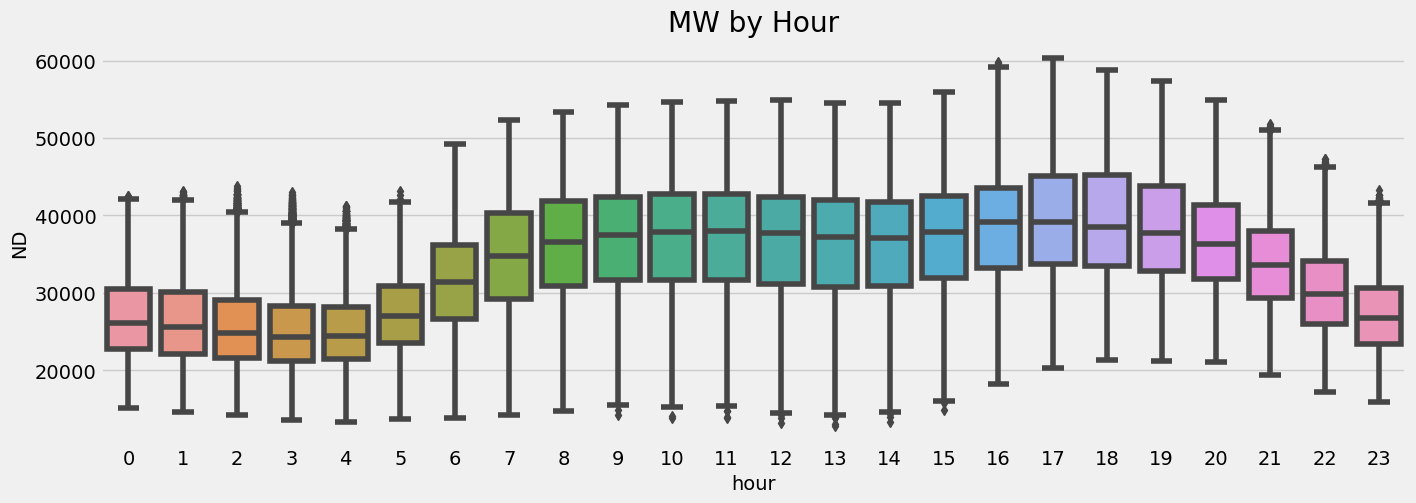

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='hour', y='ND')
ax.set_title('MW by Hour')
plt.show()

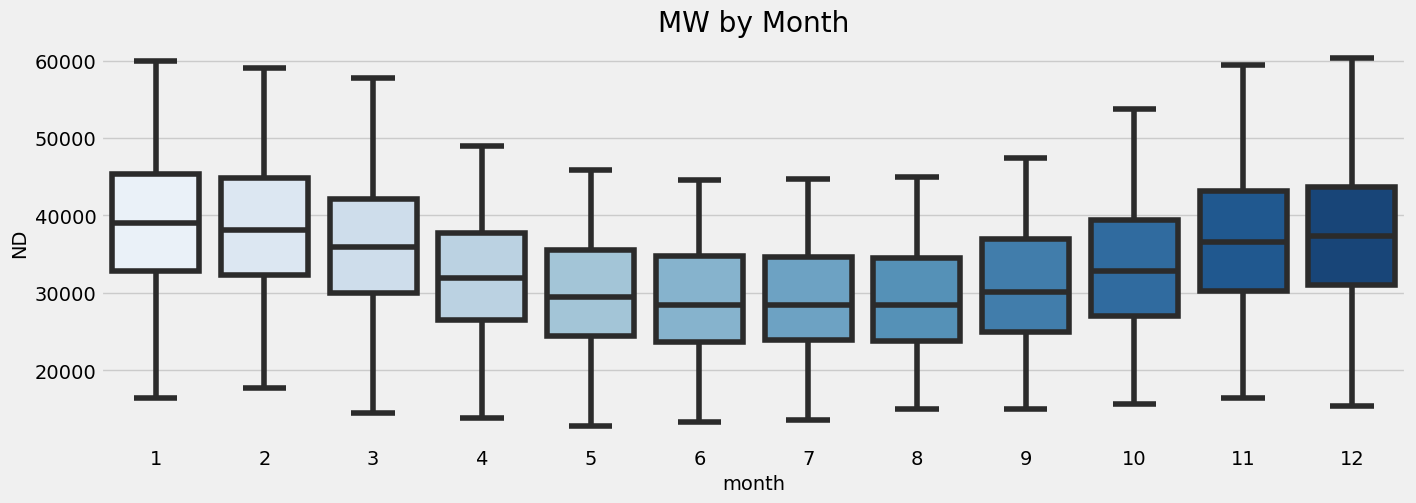

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='month', y='ND', palette = 'Blues')
ax.set_title('MW by Month')
plt.show()

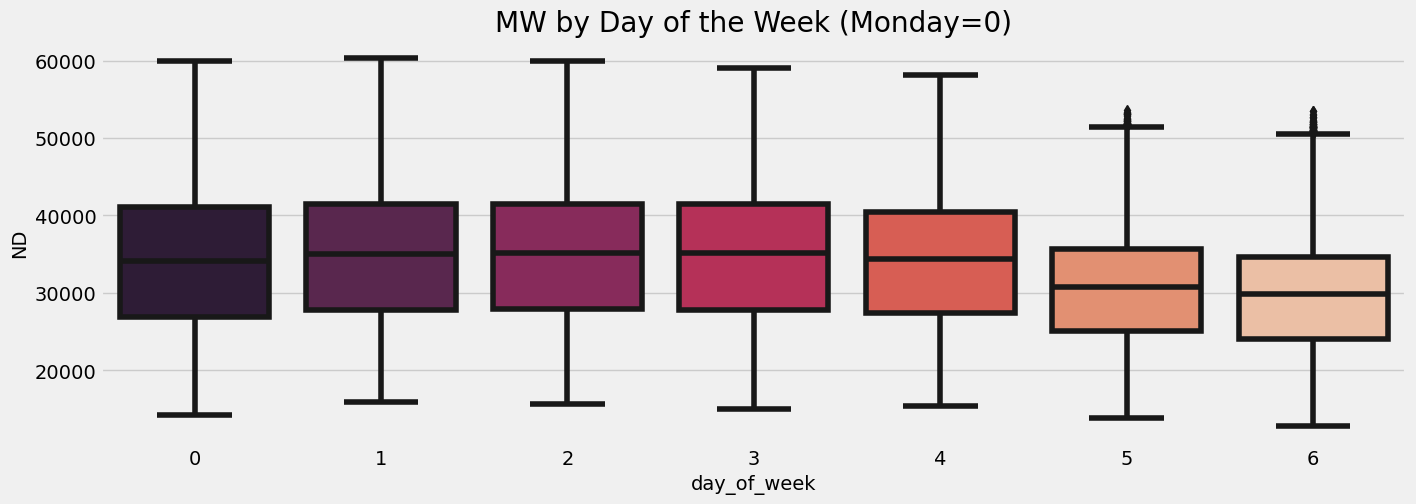

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='day_of_week', y='ND', palette = 'rocket')
ax.set_title('MW by Day of the Week (Monday=0)')
plt.show()

[Back to Contents](#Contents)

# 5. Training the Model

With our data prepared and our additional features added on, we can now train our model! WIP (although model and evaluation fully functioning working on tuning)!!

In [40]:
YEAR = 17520    # 17,532 can be used for full year as 17520 is not accounting for leap years but as neither 2025 
                # or 2026 are leap years this will keep the years we are looking at specifically aligned
GAP  = 48       # 48*30 when using rolling averages up to a month (30 days)

FEATURES = FEATURES = [
                    'day_of_week','is_weekend','quarter','month','year',
                    'day_of_year','day_of_month','week_of_year', 'UTC_settlement_period', 'local_settlement_period',
                    'ND_exactly_1_years_ago','ND_exactly_2_years_ago','ND_exactly_3_years_ago',
                    'ND_exactly_4_years_ago','ND_exactly_5_years_ago',
                    'UTC_sp_sin', 'UTC_sp_cos', 'local_sp_sin', 'local_sp_cos',
                    'is_holiday', 'IS_BST'
                    ]
TARGET = 'ND'

train_df = df.dropna(subset=[TARGET])

tscv = TimeSeriesSplit(n_splits=5, test_size=YEAR, gap=GAP )

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 15.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
    }

    rmses = []
    for tr_idx, va_idx in tscv.split(train_df):
        tr_, va_ = train_df.iloc[tr_idx], train_df.iloc[va_idx]

        if va_[TARGET].isna().all():
            continue

        model = xgb.XGBRegressor(
            **params,
            tree_method='hist',
            objective='reg:squarederror',
            eval_metric='rmse',
            random_state=17,
            n_jobs=-1,
            early_stopping_rounds=100
        )

        model.fit(
            tr_[FEATURES], tr_[TARGET],
            eval_set=[(va_[FEATURES], va_[TARGET])],
            verbose=False
        )

        pred = model.predict(va_[FEATURES])
        rmse = mean_squared_error(va_[TARGET], pred, squared=False)
        rmses.append(rmse)

    return float(np.mean(rmses))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=False)

print("Best params:", study.best_trial.params)
print("Best RMSE:", study.best_value)

[I 2025-08-14 12:55:56,081] A new study created in memory with name: no-name-3fe3d465-f6cb-43bb-978a-11c3cc63fb59
[I 2025-08-14 12:56:24,182] Trial 0 finished with value: 2332.849041172396 and parameters: {'n_estimators': 1358, 'learning_rate': 0.08841877985477908, 'max_depth': 6, 'subsample': 0.5138793999110054, 'colsample_bytree': 0.8385719740373183, 'min_child_weight': 1.2709304147817635, 'reg_lambda': 0.06384677088558388, 'reg_alpha': 4.926493967450546}. Best is trial 0 with value: 2332.849041172396.
[I 2025-08-14 12:57:02,412] Trial 1 finished with value: 2296.462557360949 and parameters: {'n_estimators': 507, 'learning_rate': 0.025581768831308017, 'max_depth': 5, 'subsample': 0.9231686226970769, 'colsample_bytree': 0.6369828524631931, 'min_child_weight': 7.1515515517175, 'reg_lambda': 2.4267554786418746, 'reg_alpha': 4.229876621880648}. Best is trial 1 with value: 2296.462557360949.
[I 2025-08-14 12:58:50,280] Trial 2 finished with value: 2298.371562875852 and parameters: {'n_est

[I 2025-08-14 13:14:58,829] Trial 21 finished with value: 2284.519546004941 and parameters: {'n_estimators': 1777, 'learning_rate': 0.030825068900212426, 'max_depth': 4, 'subsample': 0.9128624536645663, 'colsample_bytree': 0.5771030738453021, 'min_child_weight': 8.282819190675031, 'reg_lambda': 6.672481237567117, 'reg_alpha': 1.1403688557344236}. Best is trial 18 with value: 2279.8073509150704.
[I 2025-08-14 13:15:29,186] Trial 22 finished with value: 2274.789560115637 and parameters: {'n_estimators': 1794, 'learning_rate': 0.05104710799512767, 'max_depth': 6, 'subsample': 0.8691406877502889, 'colsample_bytree': 0.5677255658598771, 'min_child_weight': 3.053993205463213, 'reg_lambda': 6.421534652828793, 'reg_alpha': 1.1375378617117011}. Best is trial 22 with value: 2274.789560115637.
[I 2025-08-14 13:15:56,899] Trial 23 finished with value: 2255.6586411550875 and parameters: {'n_estimators': 1826, 'learning_rate': 0.05360536406643468, 'max_depth': 6, 'subsample': 0.8326546372151675, 'co

Best params: {'n_estimators': 1826, 'learning_rate': 0.05360536406643468, 'max_depth': 6, 'subsample': 0.8326546372151675, 'colsample_bytree': 0.5508312773228814, 'min_child_weight': 2.9454919856237076, 'reg_lambda': 5.445666155243341, 'reg_alpha': 3.031480923716327}
Best RMSE: 2255.6586411550875


In [41]:
with open("xgb_best_params.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=2)

In [42]:
with open("xgb_best_params.json", "r") as f: 
    best_params = json.load(f)
    
# Fixed hyper parameters not tuned above
best_params.update({
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "eval_metric": "rmse",
    "random_state": 17,
    "n_jobs": -1,
    "early_stopping_rounds": 100
})

In [43]:
print(best_params)

{'n_estimators': 1826, 'learning_rate': 0.05360536406643468, 'max_depth': 6, 'subsample': 0.8326546372151675, 'colsample_bytree': 0.5508312773228814, 'min_child_weight': 2.9454919856237076, 'reg_lambda': 5.445666155243341, 'reg_alpha': 3.031480923716327, 'objective': 'reg:squarederror', 'tree_method': 'hist', 'eval_metric': 'rmse', 'random_state': 17, 'n_jobs': -1, 'early_stopping_rounds': 100}


[0]	validation_0-rmse:7675.60660	validation_1-rmse:7887.99141
[100]	validation_0-rmse:1551.94614	validation_1-rmse:3374.52801
[134]	validation_0-rmse:1451.38626	validation_1-rmse:3445.82690
Fold 1: RMSE=2464.06, MAPE=7.16%


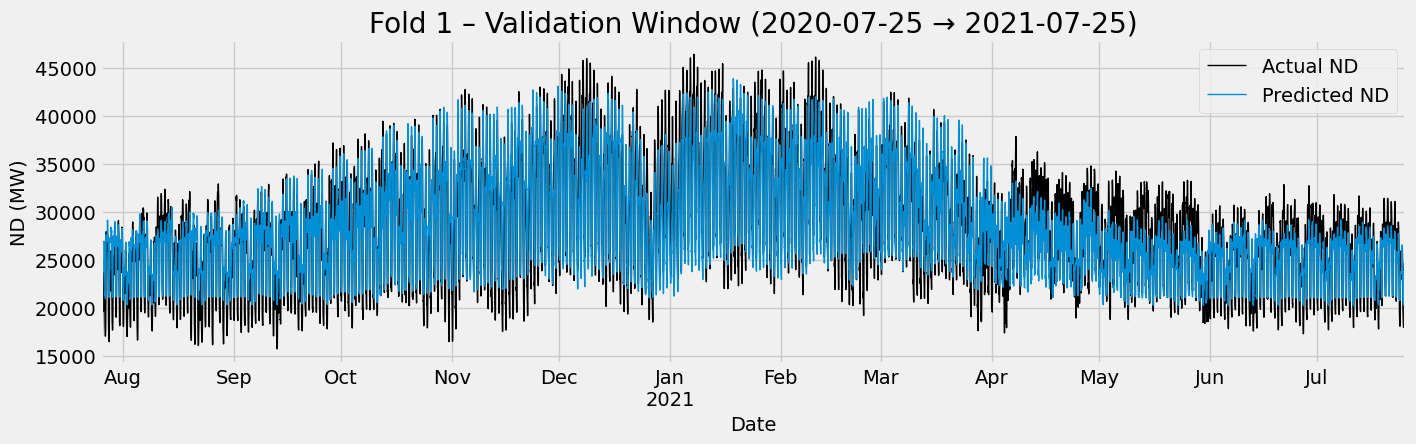

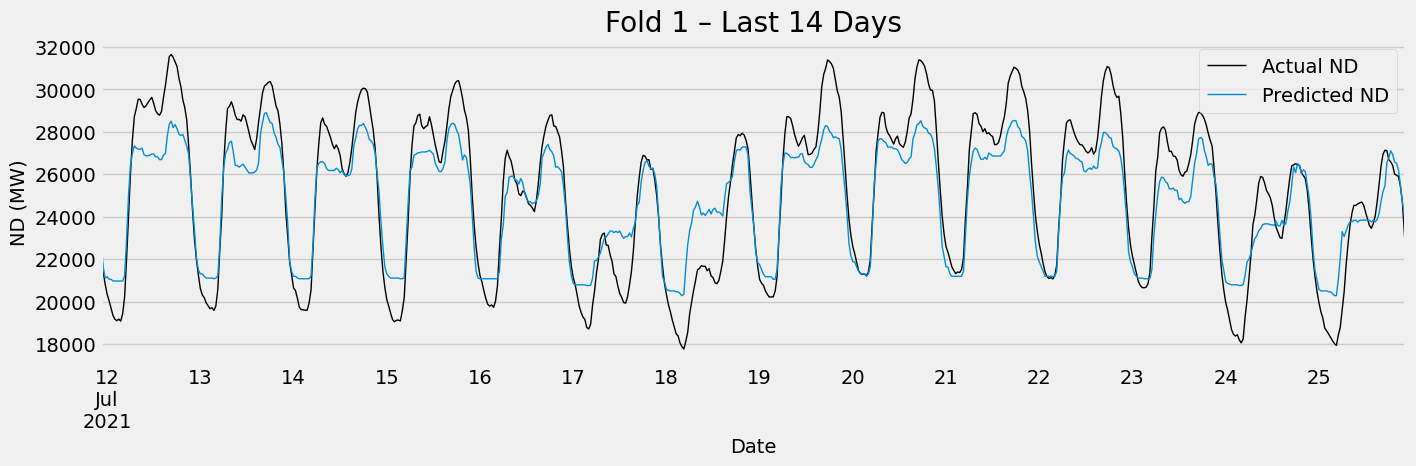

[0]	validation_0-rmse:7688.11528	validation_1-rmse:8302.77232
[100]	validation_0-rmse:1587.13549	validation_1-rmse:2140.91145
[167]	validation_0-rmse:1416.50451	validation_1-rmse:2194.38748
Fold 2: RMSE=2121.47, MAPE=6.53%


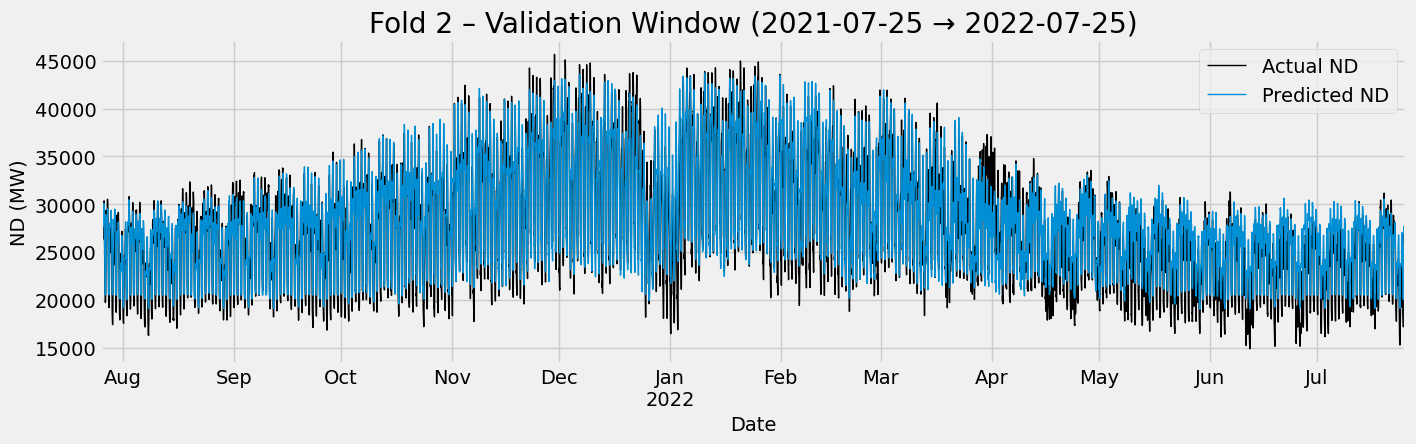

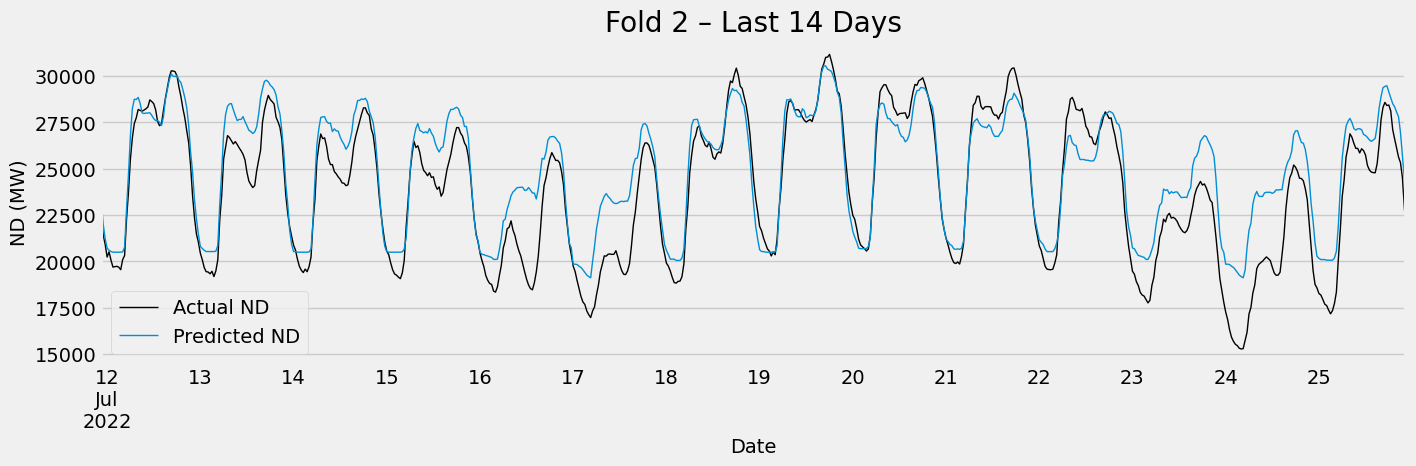

[0]	validation_0-rmse:7718.45030	validation_1-rmse:8828.35820
[100]	validation_0-rmse:1620.79880	validation_1-rmse:2240.16835
[200]	validation_0-rmse:1399.74209	validation_1-rmse:2176.55548
[265]	validation_0-rmse:1323.40463	validation_1-rmse:2175.63471
Fold 3: RMSE=2167.74, MAPE=6.54%


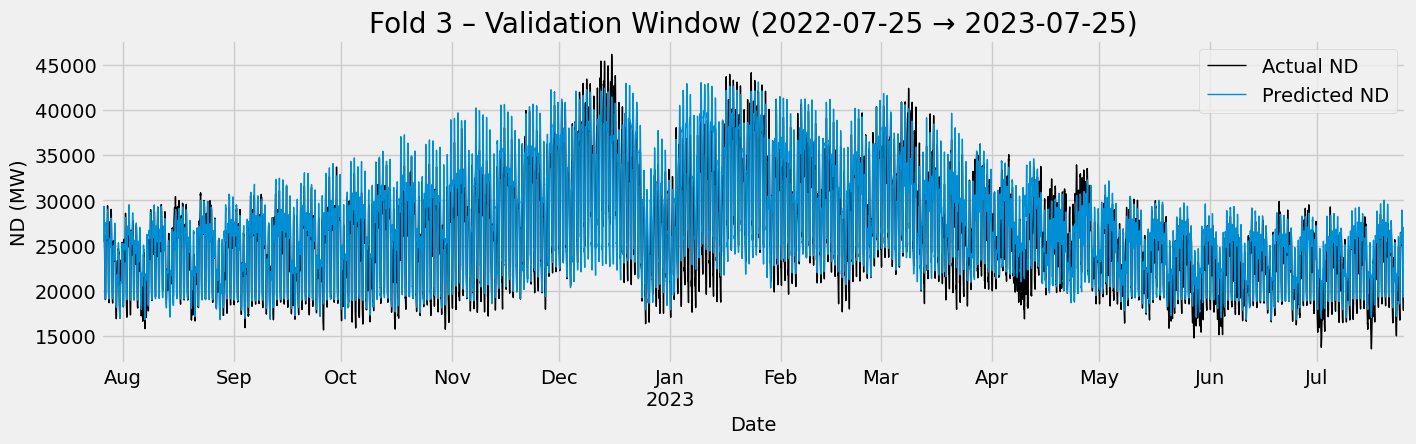

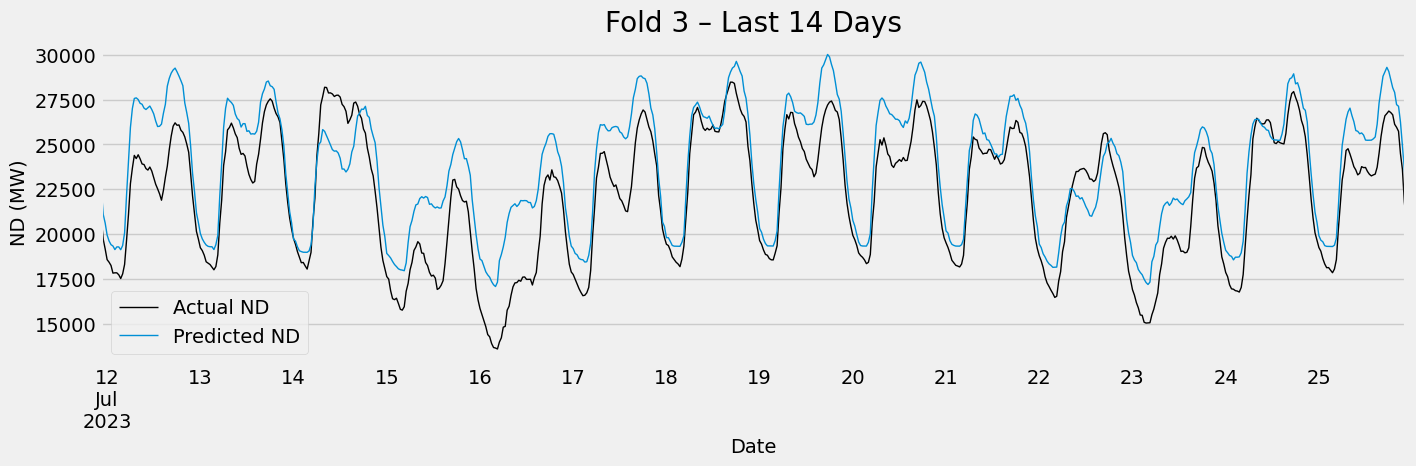

[0]	validation_0-rmse:7774.46821	validation_1-rmse:8523.13900
[100]	validation_0-rmse:1632.31907	validation_1-rmse:2218.59545
[167]	validation_0-rmse:1479.89882	validation_1-rmse:2337.74456
Fold 4: RMSE=2161.20, MAPE=6.45%


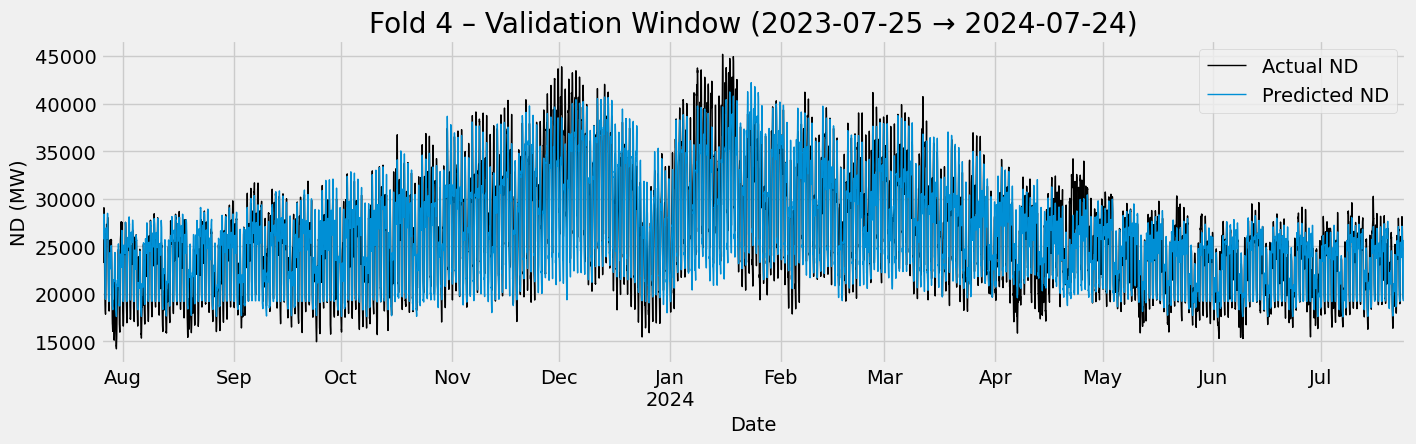

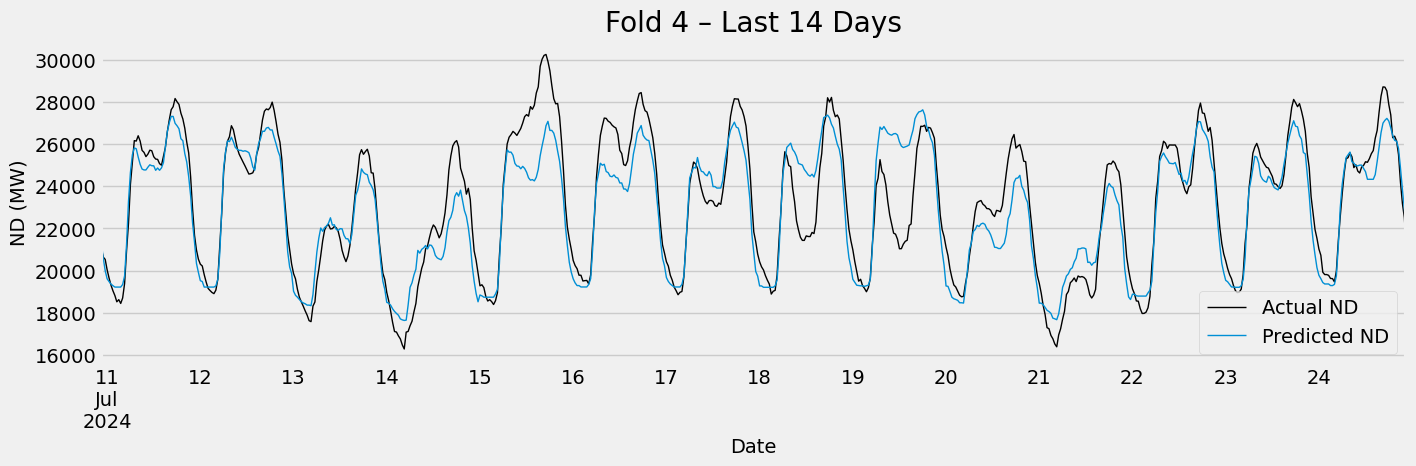

[0]	validation_0-rmse:7809.14100	validation_1-rmse:8375.22661
[100]	validation_0-rmse:1672.42321	validation_1-rmse:2563.86024
[200]	validation_0-rmse:1451.48191	validation_1-rmse:2510.96570
[277]	validation_0-rmse:1363.14358	validation_1-rmse:2526.07251
Fold 5: RMSE=2492.99, MAPE=7.35%


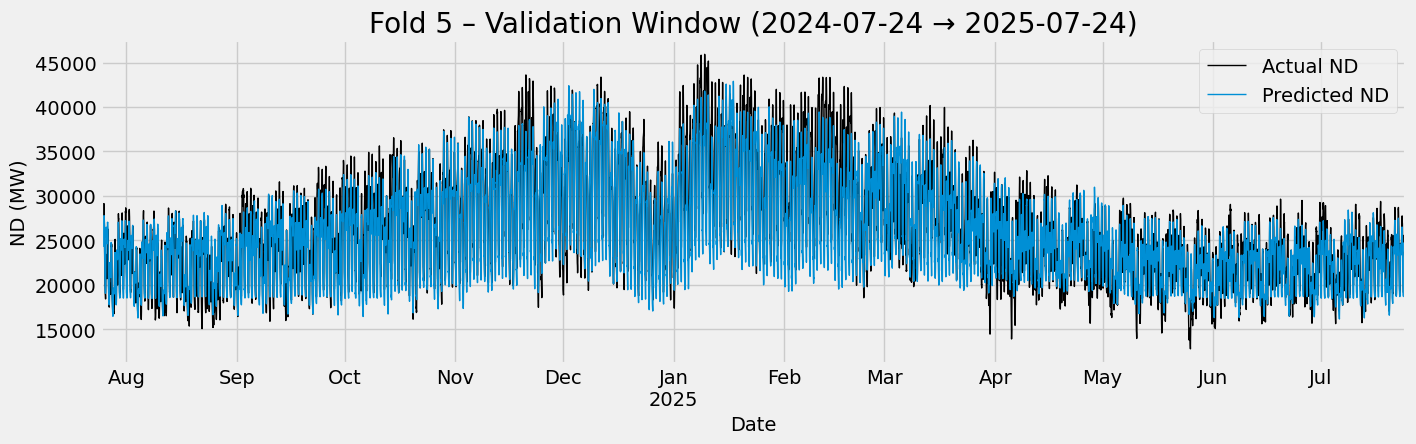

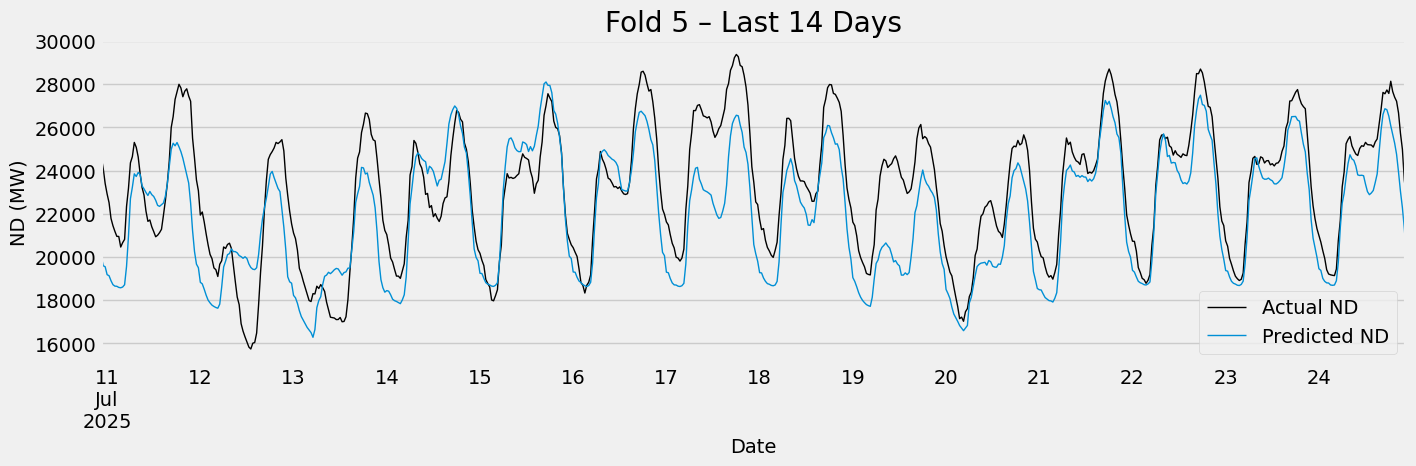

In [71]:
tss = TimeSeriesSplit(n_splits=5, test_size=YEAR, gap=GAP)
df  = df.sort_index()

# Containers
oof_pred = pd.Series(index=df.index, dtype=float, name='prediction')
fold_rmses = []
fold_mapes = []
feature_importance_list = []
scores = []

fold = 1
for train_idx, val_idx in tss.split(df):
    # Slices
    train = df.iloc[train_idx].copy()
    test  = df.iloc[val_idx].copy()

    # Keep only rows with complete data for this fold
    cols = FEATURES + [TARGET]
    train_ = train[cols].dropna()
    test_  = test[cols].dropna()

    # If a fold ends up empty after dropna (rare), skip safely
    if len(train_) == 0 or len(test_) == 0:
        print(f"Fold {fold}: skipped due to empty train/test after dropna.")
        fold += 1
        continue

    X_train, y_train = train_[FEATURES], train_[TARGET]
    X_test,  y_test  = test_[FEATURES],  test_[TARGET]

    # --- Model with tuned params ---
    reg = xgb.XGBRegressor(**best_params)

    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    # Predictions
    y_pred = reg.predict(X_test)
    oof_pred.loc[X_test.index] = y_pred

    # Fold metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    scores.append(rmse)
    mape = (np.abs(y_pred - y_test) / y_test).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100
    fold_rmses.append(rmse)
    fold_mapes.append(mape)
    print(f"Fold {fold}: RMSE={rmse:.2f}, MAPE={mape:.2f}%")

    # Feature importance this fold
    fold_feature_importance = pd.DataFrame({
        'feature': reg.feature_names_in_,
        'importance': reg.feature_importances_,
        'fold': fold
    })
    feature_importance_list.append(fold_feature_importance)

    # Plots for fold
    val_plot = pd.DataFrame({'ND': y_test, 'pred': y_pred}, index=X_test.index)

    fig, ax = plt.subplots(figsize=(15, 4))
    val_plot['ND'].plot(ax=ax, lw=1, color='black', label='Actual ND')
    val_plot['pred'].plot(ax=ax, lw=1, label='Predicted ND')
    #ax.set_title(f'Fold {fold} – Validation Window ({val_plot.index.min()} → {val_plot.index.max()})')
    ax.set_title(f'Fold {fold} – Validation Window ({val_plot.index.min().strftime("%Y-%m-%d")} → {val_plot.index.max().strftime("%Y-%m-%d")})')
    ax.set_ylabel('ND (MW)')
    ax.set_xlabel('Date')
    ax.legend()
    plt.show()

    zoom_start = val_plot.index.max() - pd.Timedelta(days=14)
    val_zoom = val_plot.loc[zoom_start:]
    fig, ax = plt.subplots(figsize=(15, 4))
    val_zoom['ND'].plot(ax=ax, lw=1, color='black', label='Actual ND')
    val_zoom['pred'].plot(ax=ax, lw=1, label='Predicted ND')
    ax.set_title(f'Fold {fold} – Last 14 Days')
    ax.set_ylabel('ND (MW)')
    ax.set_xlabel('Date')
    ax.legend()
    plt.show()

    fold += 1

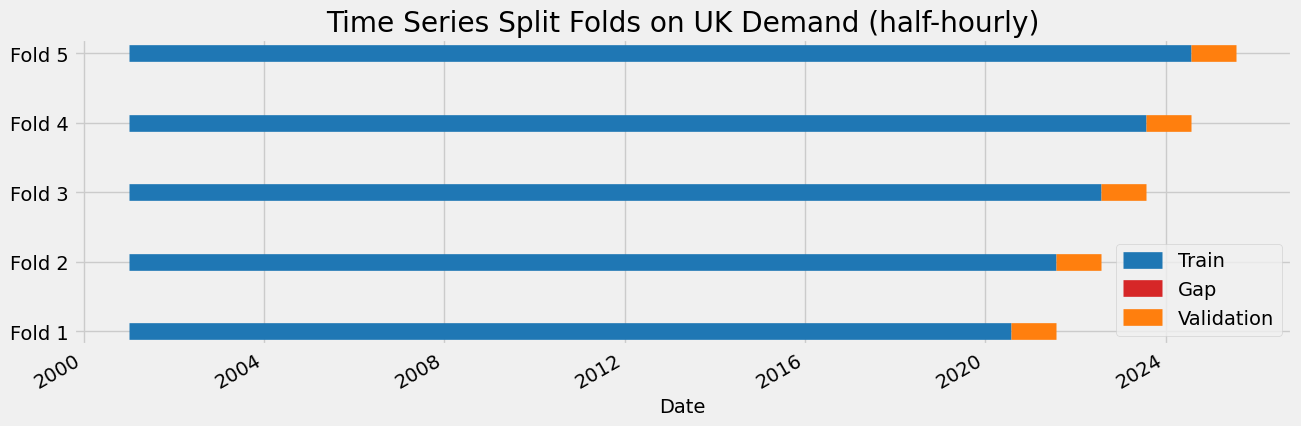

In [45]:
# Extract parameters from existing TSS object
n_splits = tss.n_splits
test_size = tss.test_size
gap = tss.gap

idx = df.index

title = "Time Series Split Folds on UK Demand (half-hourly)"
fig, ax = plt.subplots(figsize=(14, 0.5*n_splits + 2))
for fold, (train_idx, test_idx) in enumerate(tss.split(df), start=1):
    y = fold

    # Train span
    ax.hlines(y, idx[train_idx[0]], idx[train_idx[-1]],
              colors='tab:blue', linewidth=12, label='Train' if fold == 1 else None)

    # Gap span (if any)
    # There is a gap if the first test index is beyond the last train index + 1
    if test_idx[0] - train_idx[-1] > 1:
        gap_start = idx[train_idx[-1] + 1]
        gap_end   = idx[test_idx[0] - 1]
        ax.hlines(y, gap_start, gap_end,
                  colors='tab:red', linewidth=12, label='Gap' if fold == 1 else None)

    # Validation/Test span
    ax.hlines(y, idx[test_idx[0]], idx[test_idx[-1]],
              colors='tab:orange', linewidth=12, label='Validation' if fold == 1 else None)

ax.set_yticks(range(1, n_splits + 1))
ax.set_yticklabels([f'Fold {i}' for i in range(1, n_splits + 1)])
ax.set_xlabel('Date')
ax.set_title(title or f"TimeSeriesSplit (test_size={test_size}, gap={gap})")
ax.legend(loc='lower right')
fig.autofmt_xdate()
plt.show()

In [46]:
df.tail()

ND SETTLEMENT_DATETIME_LOCAL  IS_BST  hour  \
SETTLEMENT_DATETIME_UTC                                                    
2025-07-24 20:30:00+00:00  26672 2025-07-24 21:30:00+01:00       1    20   
2025-07-24 21:00:00+00:00  25725 2025-07-24 22:00:00+01:00       1    21   
2025-07-24 21:30:00+00:00  24986 2025-07-24 22:30:00+01:00       1    21   
2025-07-24 22:00:00+00:00  23553 2025-07-24 23:00:00+01:00       1    22   
2025-07-24 22:30:00+00:00  22807 2025-07-24 23:30:00+01:00       1    22   

                           minute  day_of_week  is_weekend  quarter  month  \
SETTLEMENT_DATETIME_UTC                                                      
2025-07-24 20:30:00+00:00      30            3       False        3      7   
2025-07-24 21:00:00+00:00       0            3       False        3      7   
2025-07-24 21:30:00+00:00      30            3       False        3      7   
2025-07-24 22:00:00+00:00       0            3       False        3      7   
2025-07-24 22:30:00+00:00      30            3       False        3      7   

                           year  ...  UTC_sp_cos  local_sp_sin  local_sp_cos  \
SETTLEMENT_DATETIME_UTC          ...                                           
2025-07-24 20:30:00+00:00  2025  ...    0.707107     -0.684547      0.728969   
2025-07-24 21:00:00+00:00  2025  ...    0.793353     -0.587785      0.809017   
2025-07-24 21:30:00+00:00  2025  ...    0.866025     -0.481754      0.876307   
2025-07-24 22:00:00+00:00  2025  ...    0.923880     -0.368125      0.929776   
2025-07-24 22:30:00+00:00  2025  ...    0.965926     -0.248690      0.968583   

                           holiday_name  is_holiday ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME_UTC                                                      
2025-07-24 20:30:00+00:00          None       False                25505.0   
2025-07-24 21:00:00+00:00          None       False                24191.0   
2025-07-24 21:30:00+00:00          None       False                23189.0   
2025-07-24 22:00:00+00:00          None       False                22515.0   
2025-07-24 22:30:00+00:00          None       False                21066.0   

                           ND_exactly_2_years_ago  ND_exactly_3_years_ago  \
SETTLEMENT_DATETIME_UTC                                                     
2025-07-24 20:30:00+00:00                 25436.0                 23922.0   
2025-07-24 21:00:00+00:00                 24425.0                 23341.0   
2025-07-24 21:30:00+00:00                 23220.0                 22040.0   
2025-07-24 22:00:00+00:00                 21944.0                 20737.0   
2025-07-24 22:30:00+00:00                 20894.0                 19511.0   

                           ND_exactly_4_years_ago  ND_exactly_5_years_ago  
SETTLEMENT_DATETIME_UTC                                                    
2025-07-24 20:30:00+00:00                 25797.0                 25940.0  
2025-07-24 21:00:00+00:00                 25254.0                 25164.0  
2025-07-24 21:30:00+00:00                 24288.0                 23773.0  
2025-07-24 22:00:00+00:00                 23067.0                 22368.0  
2025-07-24 22:30:00+00:00                 22001.0                 21035.0  

[5 rows x 27 columns]

[Back to Contents](#Contents)

# 6. Evaluating the Model

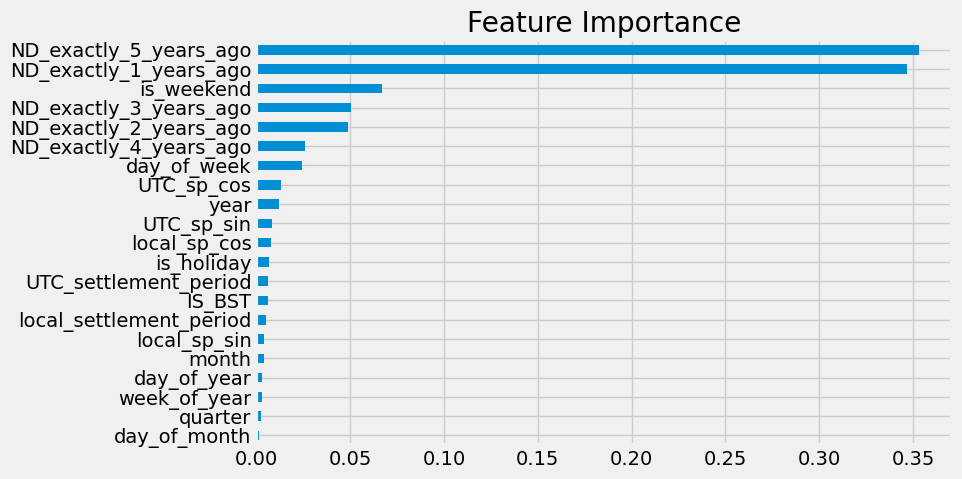

                         importance
day_of_month               0.001391
quarter                    0.002387
week_of_year               0.002958
day_of_year                0.003002
month                      0.003921
local_sp_sin               0.004191
local_settlement_period    0.005025
IS_BST                     0.006198
UTC_settlement_period      0.006253
is_holiday                 0.006928
local_sp_cos               0.007948
UTC_sp_sin                 0.008325
year                       0.011858
UTC_sp_cos                 0.013078
day_of_week                0.024322
ND_exactly_4_years_ago     0.026140
ND_exactly_2_years_ago     0.048678
ND_exactly_3_years_ago     0.050229
is_weekend                 0.067074
ND_exactly_1_years_ago     0.346752
ND_exactly_5_years_ago     0.353340
importance    1.0
dtype: float32


In [47]:
# Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi_sorted = fi.sort_values('importance')

fi_sorted.plot(kind='barh', title='Feature Importance', legend=False, figsize=(8,5))
plt.show()

print(fi_sorted)
print(fi_sorted.sum())

In [49]:
# Top level aggregated errors across whole 5 year combined validation sets

pred_df = pd.DataFrame({'ND': df[TARGET], 'prediction': oof_pred})
# Keep rows that have both actual and predicted values (combination of all folds of validation data)
valid = pred_df['ND'].notna() & pred_df['prediction'].notna()
y_true = pred_df.loc[valid, 'ND']
y_pred = pred_df.loc[valid, 'prediction']

# Error for any given prediction on combined validation sets
err   = y_pred - y_true

# MAE - Mean Absolute Error
MAE   = np.mean(np.abs(err))
# MAPE - Mean Absolute Percentage Error
eps = 1e-6
nonzero = y_true.abs() > eps
MAPE  = (np.abs(err[nonzero]) / y_true[nonzero]).mean() * 100
# sMAPE - symmetric Mean Absolute Percentage Error
den = (y_true.abs() + y_pred.abs())
valid_den = den > eps
sMAPE = (200 * (np.abs(err[valid_den]) / den[valid_den])).mean()
# wMAPE - weighted Mean Absolute Percentage Error (stable when values vary a lot)
wMAPE = (np.abs(err).sum() / np.abs(y_true).sum()) * 100

# RMSE - Root Mean Squared Error
RMSE  = np.sqrt(np.mean(err**2))
# nRMSE - normalised Root Mean Squared Error
nRMSE = RMSE / y_true.mean()


print(f"Used {valid.sum():,} OOF points for metrics (out of {len(pred_df):,}).")

print(f"\nMAE: {MAE:.2f}")
print(f"MAPE: {MAPE:.2f}%") 
print(f"sMAPE: {sMAPE:.2f}%")
print(f"wMAPE: {wMAPE:.2f}%")

print(f"\nRMSE: {RMSE:.2f}")
print(f"nRMSE: {nRMSE:.4f}")
      
print(f"\nFold specific RMSEs: {[round(s,2) for s in scores]} | Mean of fold RMSEs: {np.mean(scores):.2f}")

Used 87,600 OOF points for metrics (out of 430,606).

MAE: 1771.86
MAPE: 6.81%
sMAPE: 6.71%
wMAPE: 6.60%

RMSE: 2287.23
nRMSE: 0.0852

Fold specific RMSEs: [2464.06, 2121.47, 2167.74, 2161.2, 2492.99] | Mean of fold RMSEs: 2281.49


In [50]:
df = df.join(oof_pred) 

In [51]:
# Make DataFrame with OOF predictions and actuals
errors_df = df.copy()
errors_df['prediction'] = oof_pred
errors_df = errors_df.dropna(subset=['prediction'])  # only rows that have predictions

# Error columns
errors_df['error'] = errors_df['prediction'] - errors_df['ND']
errors_df['abs_error'] = errors_df['error'].abs()
errors_df['pct_error'] = errors_df['error'] / errors_df['ND'] * 100
errors_df['abs_pct_error'] = errors_df['pct_error'].abs()

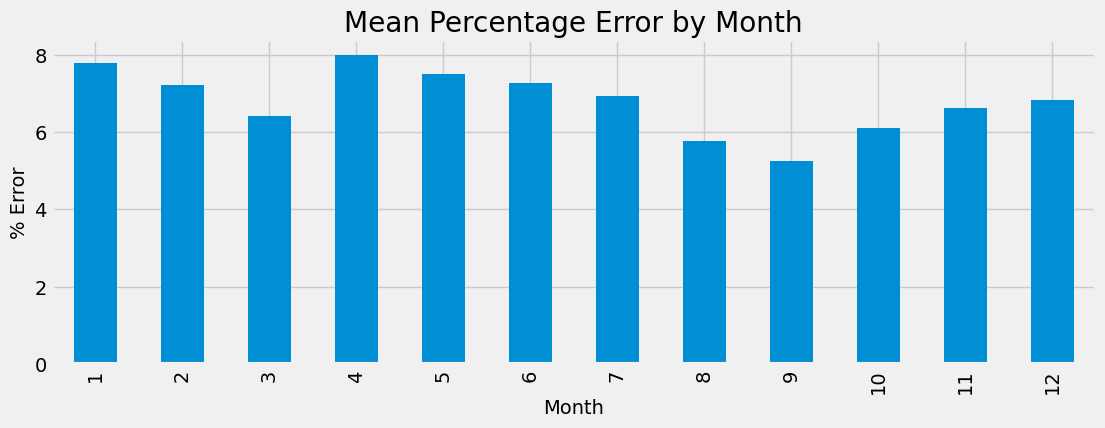

In [52]:
error_by_month = errors_df.groupby(errors_df.index.month).agg(
    mean_error=('error', 'mean'),
    mean_abs_error=('abs_error', 'mean'),
    mean_abs_pct_error=('abs_pct_error', 'mean')
)

error_by_month['mean_abs_pct_error'].plot(kind='bar', figsize=(12,4), title="Mean Percentage Error by Month")
plt.ylabel('% Error')
plt.xlabel('Month')
plt.show()

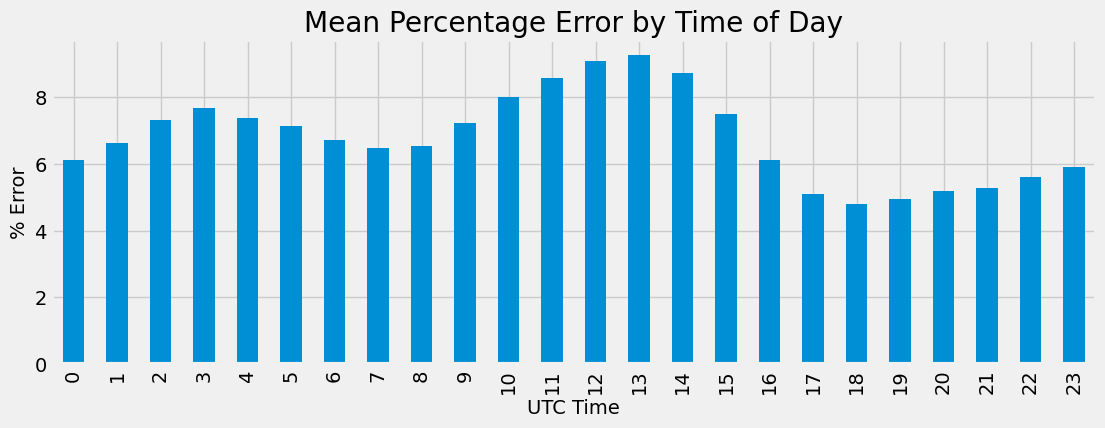

In [53]:
error_by_hour = errors_df.groupby(errors_df.index.hour).agg(
    mean_error=('error', 'mean'),
    mean_abs_error=('abs_error', 'mean'),
    mean_abs_pct_error=('abs_pct_error', 'mean')
)

error_by_hour['mean_abs_pct_error'].plot(kind='bar', figsize=(12,4), title="Mean Percentage Error by Time of Day")
plt.ylabel('% Error')
plt.xlabel('UTC Time')
plt.show()

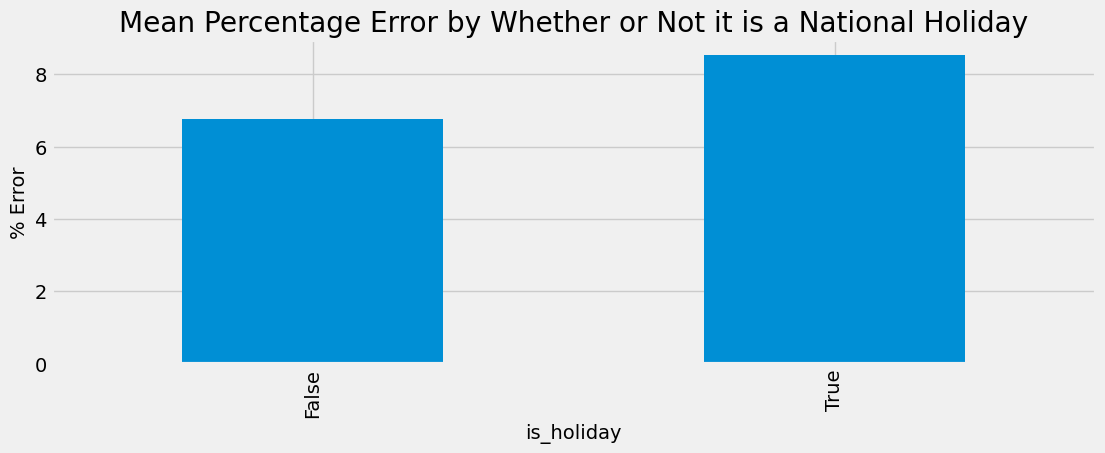

In [54]:
error_by_holiday = errors_df.groupby('is_holiday').agg(
    mean_error=('error', 'mean'),
    mean_abs_error=('abs_error', 'mean'),
    mean_abs_pct_error=('abs_pct_error', 'mean')
)

error_by_holiday['mean_abs_pct_error'].plot(kind='bar', figsize=(12,4), title="Mean Percentage Error by Whether or Not it is a National Holiday")
plt.ylabel('% Error'); plt.show()


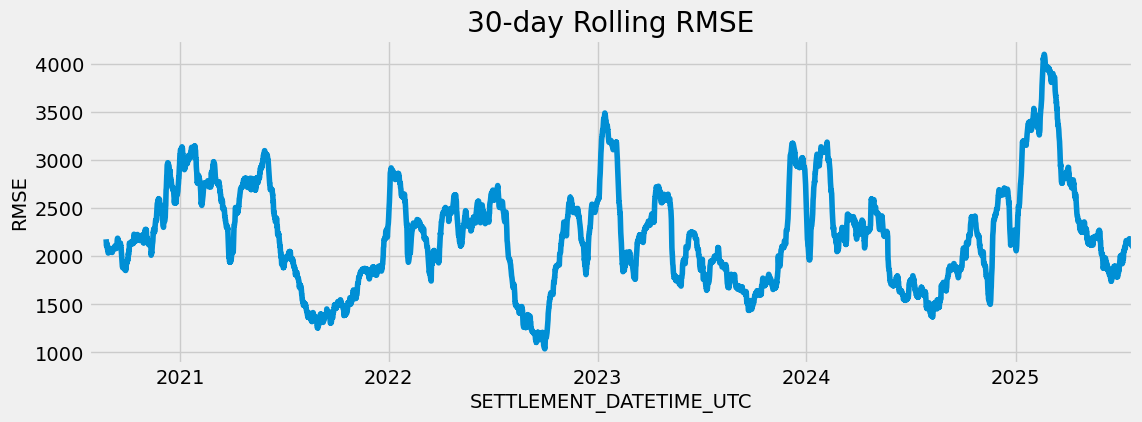

In [55]:
# residuals = actual - predicted (error for each prediction in pred_df)
residuals = pred_df['ND'] - pred_df['prediction']

# Rolling RMSE 
window_size = 48 * 30  # 30 days 
rolling_rmse = (
    residuals
    .dropna()
    .rolling(window=window_size)
    .apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
)

rolling_rmse.plot(title='30-day Rolling RMSE', figsize=(12,4))
plt.ylabel('RMSE')
plt.show()

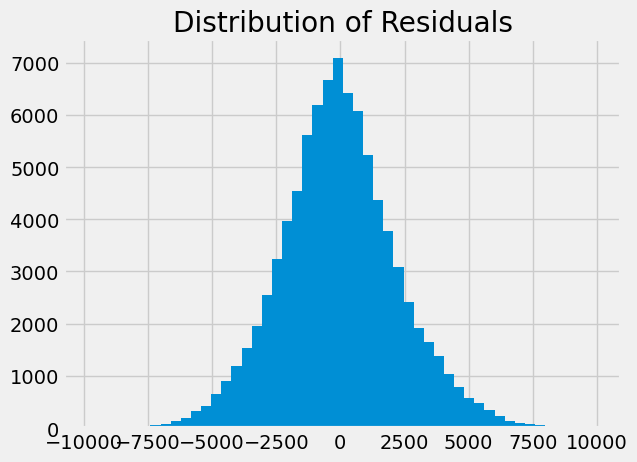

In [56]:
# Residual histogram
residuals.hist(bins=50)
plt.title("Distribution of Residuals")
plt.show()

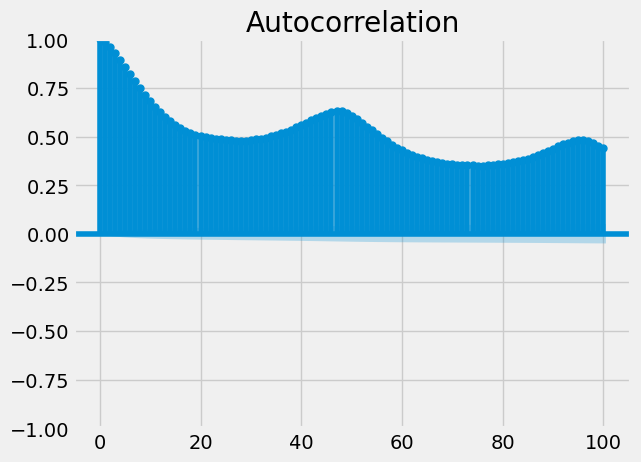

In [57]:
# Residual autocorrelation
plot_acf(residuals.dropna(), lags=100)
plt.show()

In [58]:
df.tail()

ND SETTLEMENT_DATETIME_LOCAL  IS_BST  hour  \
SETTLEMENT_DATETIME_UTC                                                    
2025-07-24 20:30:00+00:00  26672 2025-07-24 21:30:00+01:00       1    20   
2025-07-24 21:00:00+00:00  25725 2025-07-24 22:00:00+01:00       1    21   
2025-07-24 21:30:00+00:00  24986 2025-07-24 22:30:00+01:00       1    21   
2025-07-24 22:00:00+00:00  23553 2025-07-24 23:00:00+01:00       1    22   
2025-07-24 22:30:00+00:00  22807 2025-07-24 23:30:00+01:00       1    22   

                           minute  day_of_week  is_weekend  quarter  month  \
SETTLEMENT_DATETIME_UTC                                                      
2025-07-24 20:30:00+00:00      30            3       False        3      7   
2025-07-24 21:00:00+00:00       0            3       False        3      7   
2025-07-24 21:30:00+00:00      30            3       False        3      7   
2025-07-24 22:00:00+00:00       0            3       False        3      7   
2025-07-24 22:30:00+00:00      30            3       False        3      7   

                           year  ...  local_sp_sin  local_sp_cos  \
SETTLEMENT_DATETIME_UTC          ...                               
2025-07-24 20:30:00+00:00  2025  ...     -0.684547      0.728969   
2025-07-24 21:00:00+00:00  2025  ...     -0.587785      0.809017   
2025-07-24 21:30:00+00:00  2025  ...     -0.481754      0.876307   
2025-07-24 22:00:00+00:00  2025  ...     -0.368125      0.929776   
2025-07-24 22:30:00+00:00  2025  ...     -0.248690      0.968583   

                           holiday_name  is_holiday  ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME_UTC                                                       
2025-07-24 20:30:00+00:00          None       False                 25505.0   
2025-07-24 21:00:00+00:00          None       False                 24191.0   
2025-07-24 21:30:00+00:00          None       False                 23189.0   
2025-07-24 22:00:00+00:00          None       False                 22515.0   
2025-07-24 22:30:00+00:00          None       False                 21066.0   

                          ND_exactly_2_years_ago  ND_exactly_3_years_ago  \
SETTLEMENT_DATETIME_UTC                                                    
2025-07-24 20:30:00+00:00                25436.0                 23922.0   
2025-07-24 21:00:00+00:00                24425.0                 23341.0   
2025-07-24 21:30:00+00:00                23220.0                 22040.0   
2025-07-24 22:00:00+00:00                21944.0                 20737.0   
2025-07-24 22:30:00+00:00                20894.0                 19511.0   

                           ND_exactly_4_years_ago  ND_exactly_5_years_ago  \
SETTLEMENT_DATETIME_UTC                                                     
2025-07-24 20:30:00+00:00                 25797.0                 25940.0   
2025-07-24 21:00:00+00:00                 25254.0                 25164.0   
2025-07-24 21:30:00+00:00                 24288.0                 23773.0   
2025-07-24 22:00:00+00:00                 23067.0                 22368.0   
2025-07-24 22:30:00+00:00                 22001.0                 21035.0   

                             prediction  
SETTLEMENT_DATETIME_UTC                  
2025-07-24 20:30:00+00:00  23931.025391  
2025-07-24 21:00:00+00:00  23038.164062  
2025-07-24 21:30:00+00:00  22281.515625  
2025-07-24 22:00:00+00:00  21315.886719  
2025-07-24 22:30:00+00:00  20072.455078  

[5 rows x 28 columns]

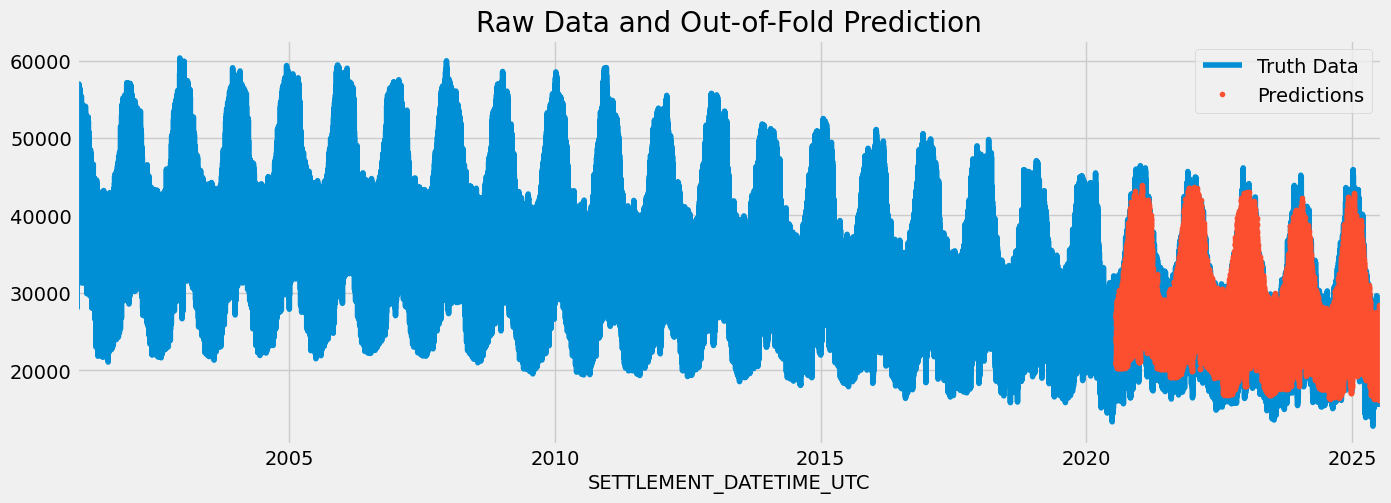

In [59]:
ax = df[['ND']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Out-of-Fold Prediction')
plt.show()

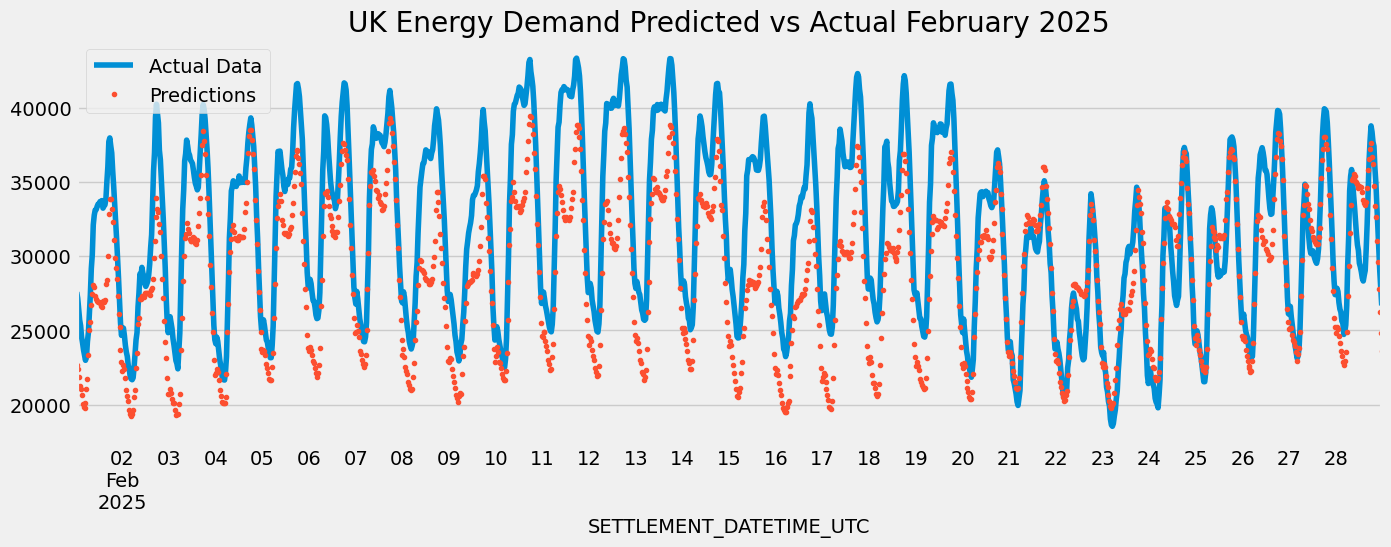

In [60]:
ax = df.loc[(df.index > '2025-02-01') & (df.index < '2025-03-01')]['ND'].plot(figsize=(15,5))
df.loc[(df.index > '2025-02-01') & (df.index < '2025-03-01')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('UK Energy Demand Predicted vs Actual February 2025')
plt.show()

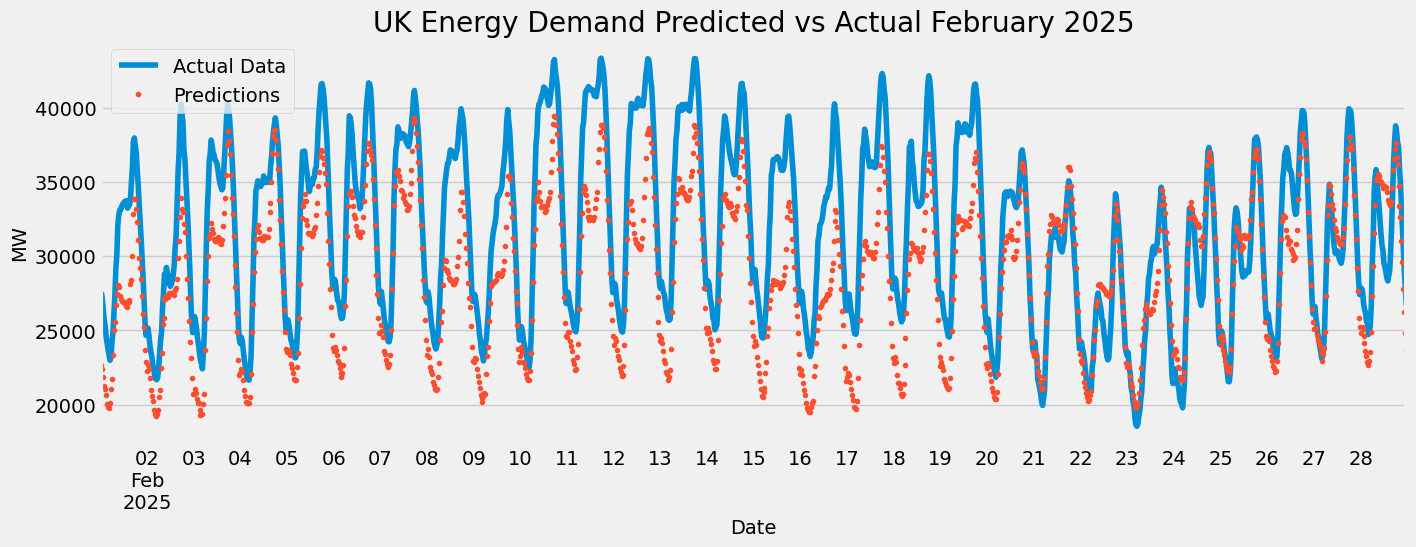

In [61]:
ax = df.loc[(df.index > '2025-02-01') & (df.index < '2025-03-01')]['ND'].plot(figsize=(15,5))
df.loc[(df.index > '2025-02-01') & (df.index < '2025-03-01')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('UK Energy Demand Predicted vs Actual February 2025')

# Add axis labels
ax.set_xlabel('Date')
ax.set_ylabel('MW')

plt.show()

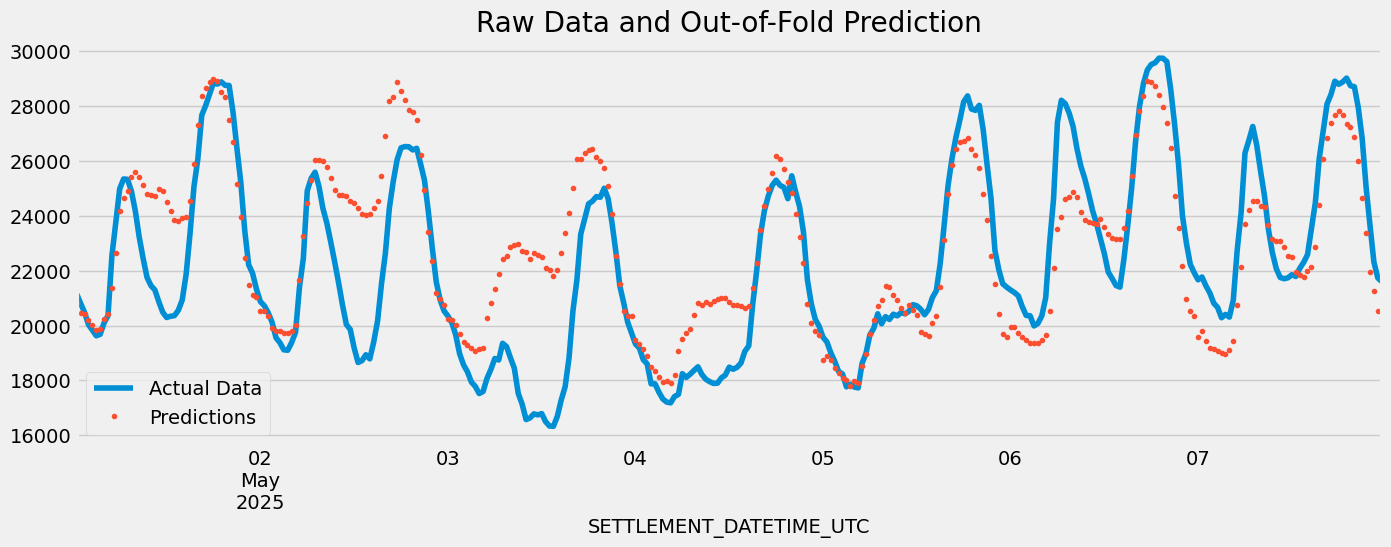

In [62]:
ax = df.loc[(df.index > '2025-05-01') & (df.index < '2025-05-08')]['ND'].plot(figsize=(15,5))
df.loc[(df.index > '2025-05-01') & (df.index < '2025-05-08')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Out-of-Fold Prediction')
plt.show()

[Back to Contents](#Contents)

# 7. Predicting Future Energy Use

In [63]:
# keep freq + tz consistent with history
freq = pd.infer_freq(df.index) or '30min'
step = pd.tseries.frequencies.to_offset(freq)

# start one step after last observed timestamp
start = df.index.max() + step

# end exactly one calendar year after start (handles leap years & DST)
end = start + pd.DateOffset(years=1)

# build future timeline; exclude the end instant itself
future = pd.date_range(start=start, end=end, freq=freq, inclusive='left')

future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

df = df.copy()
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_calendar_features(df_and_future)
df_and_future = add_calendar_lags(df_and_future)

In [64]:
future_w_features = df_and_future.query('isFuture').copy()

In [65]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

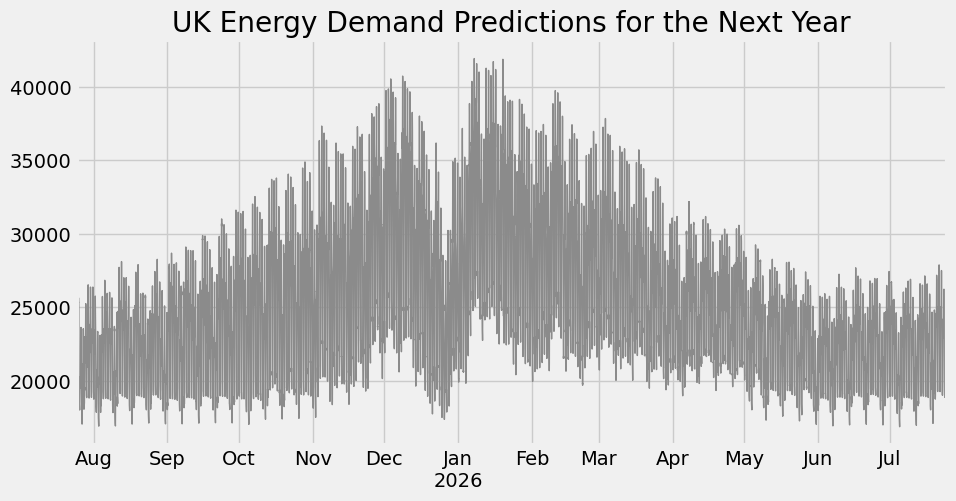

In [66]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='UK Energy Demand Predictions for the Next Year')
plt.show()

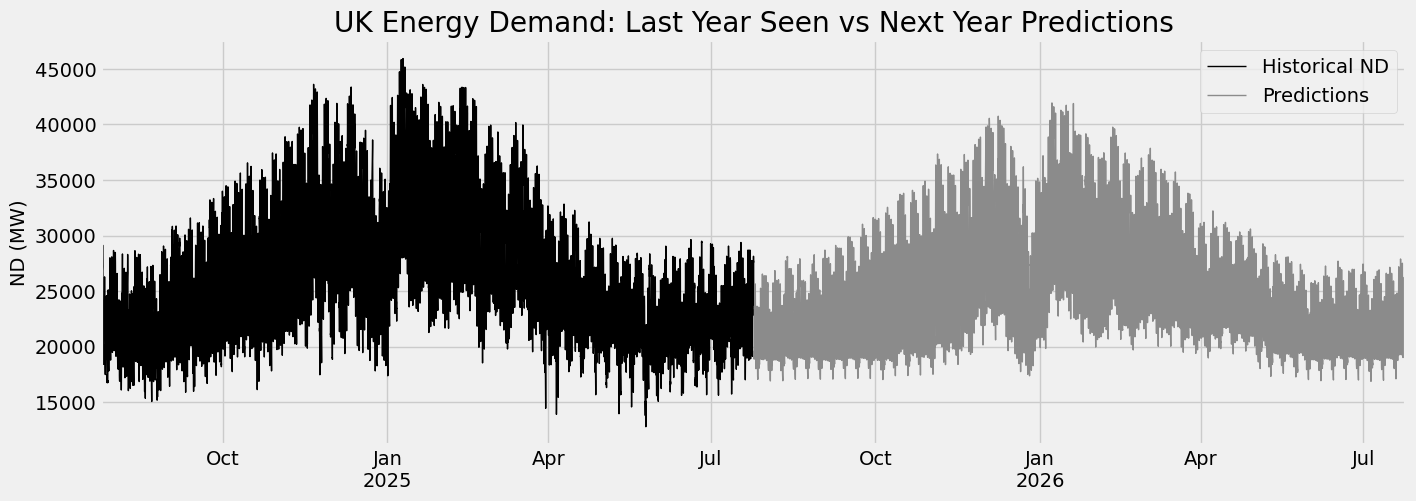

In [67]:
# Getting the last year of historical ND
last_year_start = df.index.max() - pd.DateOffset(years=1)
history_last_year = df.loc[last_year_start:].copy()

# Combining with only the predictions for the future
plot_df = pd.concat([history_last_year[['ND']], future_w_features[['pred']]])

fig, ax = plt.subplots(figsize=(15, 5))

# Historical ND
plot_df['ND'].plot(ax=ax, color='black', lw=1, label='Historical ND')

# Future predictions
plot_df['pred'].plot(ax=ax, color=color_pal[4], lw=1, label='Predictions')

ax.set_title('UK Energy Demand: Last Year Seen vs Next Year Predictions')
ax.set_ylabel('ND (MW)')
ax.legend()
plt.show()

In [68]:
# Compute residuals by settlement period (or month+sp for finer bands)
grp = errors_df.groupby('UTC_settlement_period')['error']

# 5th and 95th percentiles of errors
q_lo = grp.quantile(0.05)
q_hi = grp.quantile(0.95)

# Apply to future predictions
sp_future = future_w_features['UTC_settlement_period']
future_w_features['pred_p05'] = future_w_features['pred'] + sp_future.map(q_lo).values
future_w_features['pred_p95'] = future_w_features['pred'] + sp_future.map(q_hi).values

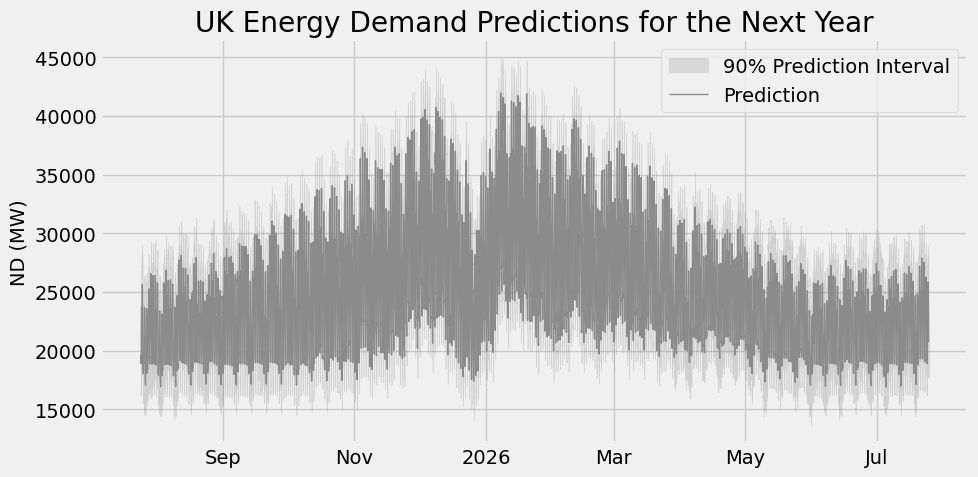

In [69]:
# Keep only the rows where all three series exist
band = future_w_features[['pred', 'pred_p05', 'pred_p95']].dropna().copy()

# Ensure index is sorted and timezone-naive
band = band.sort_index()
if band.index.tz is not None:
    x = band.index.tz_convert(None).to_pydatetime()
else:
    x = band.index.to_pydatetime()

# Make sure lower <= upper
low  = np.minimum(band['pred_p05'].values, band['pred_p95'].values)
high = np.maximum(band['pred_p05'].values, band['pred_p95'].values)

fig, ax = plt.subplots(figsize=(10, 5))

# Shaded interval
ax.fill_between(x, low, high, alpha=0.2, color='gray', label='90% Prediction Interval')

# Forecast line
ax.plot(x, band['pred'].values, lw=1, color=color_pal[4], label='Prediction')

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_title('UK Energy Demand Predictions for the Next Year')
ax.set_ylabel('ND (MW)')
ax.legend()
plt.tight_layout()
plt.show()

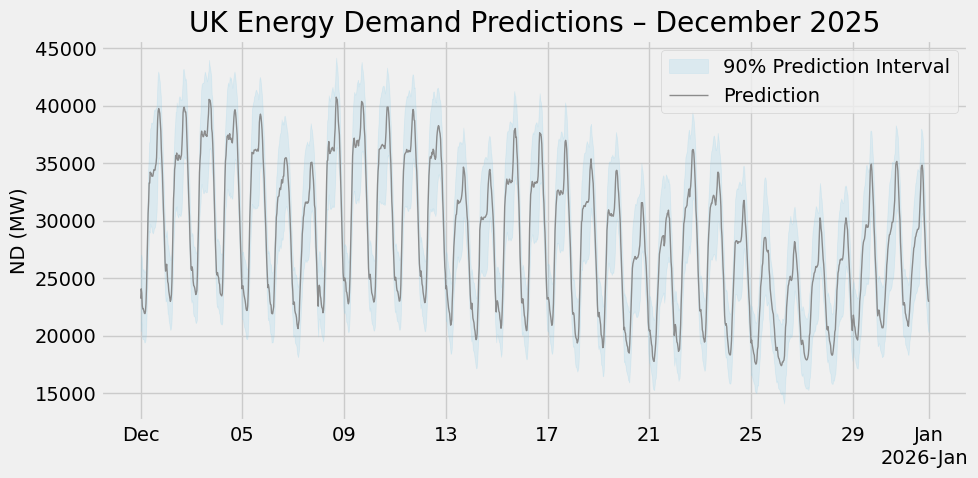

In [70]:
# December 2025
band = future_w_features[['pred', 'pred_p05', 'pred_p95']].dropna().copy()
band = band.loc['2025-12-01':'2025-12-31']

# Ensure index sorted and timezone-naive
band = band.sort_index()
if band.index.tz is not None:
    x = band.index.tz_convert(None).to_pydatetime()
else:
    x = band.index.to_pydatetime()

# Ensure lower <= upper
low  = np.minimum(band['pred_p05'].values, band['pred_p95'].values)
high = np.maximum(band['pred_p05'].values, band['pred_p95'].values)

fig, ax = plt.subplots(figsize=(10, 5))

# Shaded interval
ax.fill_between(x, low, high, alpha=0.2, color='skyblue', label='90% Prediction Interval')

# Forecast line
ax.plot(x, band['pred'].values, lw=1, color=color_pal[4], label='Prediction')

# Date formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_title('UK Energy Demand Predictions – December 2025')
ax.set_ylabel('ND (MW)')
ax.legend()
plt.tight_layout()
plt.show()


[Back to Contents](#Contents)